In [1]:
import sys; print('Python version '+str(sys.version),'\n-- suzuki.ipynb --\n')
import contextlib
import io 
import math
import numpy as np
import scipy.linalg
from scipy.linalg import expm
from scipy.linalg import sqrtm
from scipy.linalg import svd
from scipy.linalg import logm

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
mpl.style.use('classic')
my_dpi = 100
fs = 16
plt.rcParams["font.family"] = "serif"
mpl.rcParams['text.usetex'] = True
plt.rcParams["text.usetex"] = True  # Use LaTeX for text rendering
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

Python version 3.9.6 (default, Feb  3 2024, 15:58:27) 
[Clang 15.0.0 (clang-1500.3.9.4)] 
-- suzuki.ipynb --



Plotting

In [2]:
def plot_matrix_heatmap(matrix, title="Matrix Heatmap"):
    """
    Plot a matrix as a color-coded heatmap with size proportional to the matrix dimensions.
    If the matrix is complex, plot the real and imaginary parts side by side with symmetric color scales.

    Parameters:
        matrix (np.ndarray): Input matrix to be visualized.
        title (str): Title of the plot (default is "Matrix Heatmap").
    """
    # Determine the size of the figure based on matrix dimensions
    rows, cols = matrix.shape
    fig_width = 4 * (cols / max(rows, cols))
    fig_height = 4 * (rows / max(rows, cols))

    # Create figure with one or two subplots
    fig, ax = plt.subplots(1, 2 if np.iscomplexobj(matrix) else 1, figsize=(fig_width * 2, fig_height), dpi=100)
    ax = np.atleast_1d(ax)  # Ensure ax is always an array

    # Set symmetric color scale
    max_abs_value = np.max(np.abs(matrix))

    # Plot real part
    cax1 = ax[0].imshow(matrix.real, cmap="coolwarm", interpolation="nearest", aspect="equal", vmin=-max_abs_value, vmax=max_abs_value)
    ax[0].set_title("Real Part", fontsize=14)
    fig.colorbar(cax1, ax=ax[0])

    if np.iscomplexobj(matrix):
        # Plot imaginary part if matrix has complex values
        cax2 = ax[1].imshow(matrix.imag, cmap="coolwarm", interpolation="nearest", aspect="equal", vmin=-max_abs_value, vmax=max_abs_value)
        ax[1].set_title("Imaginary Part", fontsize=14)
        fig.colorbar(cax2, ax=ax[1])

    for a in ax:
        a.set_xlabel("Column Index", fontsize=12)
        a.set_ylabel("Row Index", fontsize=12)
        a.set_aspect('equal')  # Ensure each cell is a square

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


##################################################################################################################################################################


def plot_magnetizations(t, magnetization_exact, magnetization_shallow, magnetization_wide, magnetization_hybrid, 
                       delta_shallow, delta_wide, delta_hybrid, magnetization_label, fs=12, dpi=100):
    """
    General-purpose function to plot magnetization and its differences for various decomposition methods.
    
    Parameters:
        t (np.ndarray): Time array for the x-axis.
        magnetization_exact (np.ndarray): Exact magnetization array.
        magnetization_shallow (np.ndarray): Shallow decomposition magnetization array.
        magnetization_wide (np.ndarray): Wide decomposition magnetization array.
        magnetization_hybrid (np.ndarray): Hybrid decomposition magnetization array.
        delta_shallow (np.ndarray): Difference between exact and shallow magnetization.
        delta_wide (np.ndarray): Difference between exact and wide magnetization.
        delta_hybrid (np.ndarray): Difference between exact and hybrid magnetization.
        magnetization_label (str): Label for the magnetization (should include LaTeX $...$ if needed).
        fs (int, optional): Font size for labels and legends (default is 12).
        dpi (int, optional): Dots per inch for the plot resolution (default is 100).
    
    Returns:
        None
    """
    
    fig, (ax_side, ax_main) = plt.subplots(1, 2, figsize=(10, 4), dpi=dpi)  # Create side-by-side subplots
    
    # Left plot: Magnetization for each decomposition
    ax_side.plot(t, magnetization_shallow, label=magnetization_label + r"$^{\mathrm{shallow}}$", color="blue", linewidth=1)
    ax_side.plot(t, magnetization_wide, label=magnetization_label + r"$^{\mathrm{wide}}$", color="red", linewidth=1)
    ax_side.plot(t, magnetization_hybrid, label=magnetization_label + r"$^{\mathrm{hybrid}}$", color="orange", linewidth=1, linestyle="dashed")
    ax_side.plot(t, magnetization_exact, label=magnetization_label + r"$^{\mathrm{exact}}$", color="black", linewidth=1)
    ax_side.set_xlabel(r"$t$", fontsize=fs)
    ax_side.set_ylabel(f"{magnetization_label} per spin", fontsize=fs)
    ax_side.legend(fontsize=fs - 2)
    ax_side.grid(True, linestyle="--", alpha=0.7)
    
    # Right plot: Difference in Magnetization
    ax_main.plot(t, delta_shallow, label=magnetization_label + r" - " + magnetization_label + r"$^{\mathrm{shallow}}$", color="blue", linewidth=1)
    ax_main.plot(t, delta_wide, label=magnetization_label + r" - " + magnetization_label + r"$^{\mathrm{wide}}$", color="red", linewidth=1)
    ax_main.plot(t, delta_hybrid, label=magnetization_label + r" - " + magnetization_label + r"$^{\mathrm{hybrid}}$", color="orange", linewidth=1, linestyle="dashed")
    ax_main.set_xlabel(r"$t$", fontsize=fs)
    ax_main.set_ylabel(f"Difference in {magnetization_label}", fontsize=fs)
    ax_main.legend(fontsize=fs)
    ax_main.grid(True, linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()


########################################################################################################################################################################


def plot_distance_measures(distances_shallow, distances_wide, distances_hybrid, t):
    """
    Plot the distance measures between time-evolved propagators for shallow, wide, and hybrid decompositions.
    
    Parameters:
        distances_shallow (dict): Dictionary of distance measures for the shallow decomposition.
        distances_wide (dict): Dictionary of distance measures for the wide decomposition.
        distances_hybrid (dict): Dictionary of distance measures for the hybrid decomposition.
        t (np.ndarray): Time array for the x-axis.
    
    Returns:
        None
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    measures = ["fidelity", "1 - bures_distance", "1 - trace_distance", "relative_entropy"]
    y_labels = ["Fidelity", "1 - Bures Distance", "1 - Trace Distance", "Relative Entropy"]

    # Preprocess the distances to create 1 - values for Bures and Trace distances
    processed_distances = {
        "1 - bures_distance": {
            "shallow": 1 - distances_shallow["bures_distance"],
            "wide": 1 - distances_wide["bures_distance"],
            "hybrid": 1 - distances_hybrid["bures_distance"]
        },
        "1 - trace_distance": {
            "shallow": 1 - distances_shallow["trace_distance"],
            "wide": 1 - distances_wide["trace_distance"],
            "hybrid": 1 - distances_hybrid["trace_distance"]
        },
        "fidelity": {
            "shallow": distances_shallow["fidelity"],
            "wide": distances_wide["fidelity"],
            "hybrid": distances_hybrid["fidelity"]
        },
        "relative_entropy": {
            "shallow": distances_shallow["relative_entropy"],
            "wide": distances_wide["relative_entropy"],
            "hybrid": distances_hybrid["relative_entropy"]
        }
    }

    for i, (measure, y_label) in enumerate(zip(measures, y_labels)):
        ax = axes[i]
        ax.plot(t, processed_distances[measure]["shallow"], label="Shallow", color="blue", linewidth=1.5)
        ax.plot(t, processed_distances[measure]["wide"], label="Wide", color="red", linewidth=1.5)
        ax.plot(t, processed_distances[measure]["hybrid"], label="Hybrid", color="orange", linewidth=1.5)
        
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.set_ylabel(y_label, fontsize=12)  # Set y-axis label instead of a title
        
        if i >= 2:
            ax.set_xlabel(r"$t$", fontsize=12)
        
        # Disable scientific notation offset text on the y-axis
        ax.ticklabel_format(style="plain", axis="y")
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))

    # Add a shared legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", fontsize=12, ncol=3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


########################################################################################################################################################################


def plot_distance_measures_forced(distances_shallow, distances_forced, distances_wide, t, wide_probabilities):
    """
    Plot the distance measures for shallow, forced, and wide decompositions with a color gradient for the forced lines.

    Parameters:
        distances_shallow (dict): Dictionary of distance measures for the shallow decomposition.
        distances_forced (dict): Dictionary of distance measures for each wide_probability in the forced decomposition.
        distances_wide (dict): Dictionary of distance measures for the wide decomposition.
        t (np.ndarray): Time array for the x-axis.
        wide_probabilities (list or np.ndarray): List of wide probabilities used in the forced decomposition.

    Returns:
        None
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    measures = ["fidelity", "1 - bures_distance", "1 - trace_distance", "relative_entropy"]
    y_labels = ["Fidelity", "1 - Bures Distance", "1 - Trace Distance", "Relative Entropy"]

    # Create a new colormap by cutting out the white region (0.45 to 0.55) in `bwr`
    cut_colormap = LinearSegmentedColormap.from_list(
        "trimmed_bwr", 
        cm.bwr(np.linspace(0, 1, 1000))[np.logical_or(np.linspace(0, 1, 1000) < 0.45, np.linspace(0, 1, 1000) > 0.55)]
    )
    # Generate colors for forced decompositions using the new trimmed colormap
    colors = cut_colormap(np.linspace(0, 1, len(wide_probabilities)))

    # Preprocess distances: calculate "1 -" for Bures and Trace distances
    processed_distances_forced = {
        prob: {
            "1 - bures_distance": 1 - distances_forced[prob]["bures_distance"],
            "1 - trace_distance": 1 - distances_forced[prob]["trace_distance"],
            "fidelity": distances_forced[prob]["fidelity"],
            "relative_entropy": distances_forced[prob]["relative_entropy"]
        }
        for prob in wide_probabilities
    }

    processed_distances_shallow = {
        "1 - bures_distance": 1 - distances_shallow["bures_distance"],
        "1 - trace_distance": 1 - distances_shallow["trace_distance"],
        "fidelity": distances_shallow["fidelity"],
        "relative_entropy": distances_shallow["relative_entropy"]
    }

    processed_distances_wide = {
        "1 - bures_distance": 1 - distances_wide["bures_distance"],
        "1 - trace_distance": 1 - distances_wide["trace_distance"],
        "fidelity": distances_wide["fidelity"],
        "relative_entropy": distances_wide["relative_entropy"]
    }

    for i, (measure, y_label) in enumerate(zip(measures, y_labels)):
        ax = axes[i]

        # Plot forced decompositions with a color gradient
        for j, prob in enumerate(wide_probabilities):
            ax.plot(t, processed_distances_forced[prob][measure], color=colors[j], linewidth=1.5, alpha=0.8)

        # Plot shallow and wide decompositions
        ax.plot(t, processed_distances_shallow[measure], color="darkblue", linewidth=1.5)
        ax.plot(t, processed_distances_wide[measure], color="darkred", linewidth=1.5)

        ax.grid(True, linestyle="--", alpha=0.7)
        ax.set_ylabel(y_label, fontsize=12)
        if i >= 2:
            ax.set_xlabel(r"$t$", fontsize=12)
        ax.ticklabel_format(style="plain", axis="y")
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))

    # Create custom patches for the legend
    custom_patches = [
        mpatches.Patch(color=colors[j], label=f"Forced {prob:.1f}") for j, prob in enumerate(wide_probabilities)
    ]
    shallow_patch = mpatches.Patch(color="darkblue", label="Shallow")
    wide_patch = mpatches.Patch(color="darkred", label="Wide")

    # Add a shared legend with custom order
    fig.legend(
        [shallow_patch] + custom_patches + [wide_patch],
        ["Shallow"] + [f"Forced {prob:.1f}" for prob in wide_probabilities] + ["Wide"],
        loc="upper center", fontsize=10, ncol=4
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


########################################################################################################################################################################

    
def plot_distance_measures_all(distances_shallow, distances_forced, distances_wide, distances_hybrid, t, wide_probabilities):
    """
    Plot the distance measures for shallow, forced, wide, and hybrid decompositions with a color gradient for the forced lines.
    Automatically adjusts y-axis limits to improve visualization.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    measures = ["fidelity", "1 - bures_distance", "1 - trace_distance", "relative_entropy"]
    y_labels = ["Fidelity", "1 - Bures Distance", "1 - Trace Distance", "Relative Entropy"]

    # Create a custom colormap by trimming the white region from `bwr`
    cut_colormap = LinearSegmentedColormap.from_list(
        "trimmed_bwr", 
        cm.bwr(np.linspace(0, 1, 1000))[np.logical_or(np.linspace(0, 1, 1000) < 0.45, np.linspace(0, 1, 1000) > 0.55)]
    )
    
    # Generate colors for the forced decompositions
    colors = cut_colormap(np.linspace(0, 1, len(wide_probabilities)))

    # Preprocess distances
    processed_distances = lambda d: {
        "1 - bures_distance": 1 - d["bures_distance"],
        "1 - trace_distance": 1 - d["trace_distance"],
        "fidelity": d["fidelity"],
        "relative_entropy": d["relative_entropy"]
    }

    processed_distances_shallow = processed_distances(distances_shallow)
    processed_distances_wide = processed_distances(distances_wide)
    processed_distances_hybrid = processed_distances(distances_hybrid)
    processed_distances_forced = {
        prob: processed_distances(distances_forced[prob]) for prob in wide_probabilities
    }

    for i, (measure, y_label) in enumerate(zip(measures, y_labels)):
        ax = axes[i]

        # Plot forced decompositions with a color gradient
        for j, prob in enumerate(wide_probabilities):
            ax.plot(t, processed_distances_forced[prob][measure], color=colors[j], linewidth=1.5, alpha=0.8)

        # Plot shallow, wide, and hybrid decompositions
        ax.plot(t, processed_distances_shallow[measure], color="darkblue", linewidth=1.5)
        ax.plot(t, processed_distances_wide[measure], color="darkred", linewidth=1.5)
        ax.plot(t, processed_distances_hybrid[measure], color="orange", linewidth=1.5)

        ax.grid(True, linestyle="--", alpha=0.7)
        ax.set_ylabel(y_label, fontsize=12)
        if i >= 2:
            ax.set_xlabel(r"$t$", fontsize=12)

    # Create custom patches for the legend
    custom_patches = [
        mpatches.Patch(color=colors[j], label=f"Forced {prob:.1f}") for j, prob in enumerate(wide_probabilities)
    ]
    shallow_patch = mpatches.Patch(color="darkblue", label="Shallow")
    wide_patch = mpatches.Patch(color="darkred", label="Wide")
    hybrid_patch = mpatches.Patch(color="orange", label="Hybrid")

    # Add a shared legend with custom order
    fig.legend(
        [shallow_patch] + custom_patches + [wide_patch, hybrid_patch],
        ["Shallow"] + [f"Forced {prob:.1f}" for prob in wide_probabilities] + ["Wide", "Hybrid"],
        loc="upper center", fontsize=10, ncol=4
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    

    

Simple functions

In [13]:
def check_does_commute(A, B):
    """Check if two matrices commute: [A, B] = AB - BA"""
    return np.allclose(A @ B, B @ A)


##################################################################################################################################################################


def check_does_commute(A, B):
    """Check if two matrices commute: [A, B] = AB - BA"""
    return np.allclose(A @ B, B @ A)


##################################################################################################################################################################


# Depolarising noise. 
def depolarise(array,p):
    return p*np.eye(array.shape[0])/array.shape[0] + (1-p)*array


##################################################################################################################################################################


def dagger(matrix):
    """
    Computes the complex conjugate transpose (dagger) of a matrix.

    Parameters:
        matrix (np.ndarray): Input matrix.

    Returns:
        np.ndarray: The complex conjugate transpose of the input matrix.
    """
    return np.conjugate(matrix).T


##################################################################################################################################################################


def sequential_matrix_product(U_array):
    """
    Computes the ordered product of matrices in U_array using a loop.

    Parameters:
        U_array (np.ndarray): Array of shape (N_ops, dim, dim).

    Returns:
        np.ndarray: The final time evolution operator (dim, dim).
    """
    U_total = np.eye(U_array.shape[1], dtype=complex)  # Identity matrix of size (dim, dim)
    for U in U_array:
        U_total = U @ U_total  # Right multiplication to maintain order
    return U_total


##################################################################################################################################################################


def fidelity(rho, sigma):
    """
    Computes the fidelity between two density matrices. Gives the overlap between the states.
    D = 0 if rho and sigma are orthogonal states 
    D = 1 if rho = sigma 

    Parameters:
        rho (np.ndarray): First density matrix (dim x dim) or array (Nt, dim, dim).
        sigma (np.ndarray): Second density matrix (dim x dim) or array (Nt, dim, dim).

    Returns:
        float or np.ndarray: Fidelity as a float (for single matrices) or array (for time-dependent matrices).
    """
    assert rho.shape == sigma.shape, "Density matrices must have the same shape."

    if rho.ndim == 3:
        fidelities = np.array([fidelity(rho_t, sigma_t) for rho_t, sigma_t in zip(rho, sigma)])
        return fidelities

    sqrt_rho = sqrtm(rho)
    intermediate = sqrt_rho @ sigma @ sqrt_rho
    sqrt_intermediate = sqrtm(intermediate)
    fidelity_value = np.real(np.trace(sqrt_intermediate)) ** 2
    return min(max(fidelity_value, 0), 1)


##################################################################################################################################################################


def fidelity_to_bures(fidelity):
    """
    Converts fidelity to the Bures distance. Bures distance corresponds to the shortest geodesic distance between two density matrices on the space of quantum states.
    D = 0 if rho = sigma 
    D = 1 if rho and sigma are orthogonal pure states 

    Parameters:
        fidelity (float or np.ndarray): Fidelity between two density matrices (must be in [0, 1]).
                                        Can be a single value or an array of fidelity values.

    Returns:
        float or np.ndarray: Bures distance corresponding to the given fidelity.
                            Returns a float if the input is a single fidelity, or an array if the input is an array of fidelities.
    """
    if np.isscalar(fidelity):
        assert 0 <= fidelity <= 1, "Fidelity must be between 0 and 1."
        return np.sqrt(2 - 2 * np.sqrt(fidelity)) / np.sqrt(2)
    else:
        assert np.all((fidelity >= 0) & (fidelity <= 1)), "All fidelity values must be between 0 and 1."
        return np.sqrt(2 - 2 * np.sqrt(fidelity)) / np.sqrt(2)


##################################################################################################################################################################


def fidelity_and_bures_distance(rho, sigma):
    """
    Computes both the fidelity and the Bures distance between two density matrices.

    Parameters:
        rho (np.ndarray): First density matrix (dim x dim).
        sigma (np.ndarray): Second density matrix (dim x dim).

    Returns:
        float: Fidelity between rho and sigma.
        float: Bures distance between rho and sigma.
    """
    # Compute the fidelity between rho and sigma
    fidelity_value = fidelity(rho, sigma)
    
    # Convert fidelity to Bures distance
    bures_distance_value = fidelity_to_bures(fidelity_value)
    
    return fidelity_value, bures_distance_value


##################################################################################################################################################################


def frobenius_distance(rho, sigma):
    """
    Computes the Frobenius distance between two matrices (rho and sigma). Just a matrix norm, so two states that are physically close might appear far in Frobenius 
    distance if they differ by a unitary transformation. 
    D = 0 if rho = sigma 
    D = 1 if rho and sigma are orthogonal pure states 

    Parameters:
        rho (np.ndarray): First matrix (dim x dim) or array (Nt, dim, dim).
        sigma (np.ndarray): Second matrix (dim x dim) or array (Nt, dim, dim).

    Returns:
        float or np.ndarray: Frobenius distance as a float (for single matrices) or array (for time-dependent matrices).
    """
    assert rho.shape == sigma.shape, "Matrices must have the same shape."

    if rho.ndim == 3:
        distances = np.array([np.linalg.norm(rho_t - sigma_t, 'fro') / np.sqrt(2) for rho_t, sigma_t in zip(rho, sigma)])
        return distances

    return np.linalg.norm(rho - sigma, 'fro') / np.sqrt(2)


##################################################################################################################################################################


def trace_distance(rho, sigma):
    """
    Computes the trace distance between two density matrices. The trace distance quantifies the maximum distinguishability between two quantum states.
    D = 0 if rho = sigma
    D = 1 if rho and sigma are completely orthogonal (fully distinguishable)

    Parameters:
        rho (np.ndarray): First density matrix (dim x dim) or array (Nt, dim, dim).
        sigma (np.ndarray): Second density matrix (dim x dim) or array (Nt, dim, dim).

    Returns:
        float or np.ndarray: Trace distance as a float (for single matrices) or array (for time-dependent matrices).
    """
    assert rho.shape == sigma.shape, "Density matrices must have the same shape."

    if rho.ndim == 3:
        distances = np.array([trace_distance(rho_t, sigma_t) for rho_t, sigma_t in zip(rho, sigma)])
        return distances

    delta = rho - sigma
    singular_values = svd(delta, compute_uv=False)
    return 0.5 * np.sum(np.abs(singular_values))


##################################################################################################################################################################


def relative_entropy(rho, sigma):
    """
    Computes the quantum relative entropy S(rho || sigma), also called the quantum Kullback–Leibler divergence. Quantifies how much information is lost when 
    approximating rho with sigma. 
    D = 0 if rho = sigma 
    D --> inf if sigma has zero eigenvalues and rho is non-zero

    Parameters:
        rho (np.ndarray): First density matrix (dim x dim) or array (Nt, dim, dim).
        sigma (np.ndarray): Second density matrix (dim x dim) or array (Nt, dim, dim).

    Returns:
        float or np.ndarray: Quantum relative entropy as a float (for single matrices) or array (for time-dependent matrices).
    """
    assert rho.shape == sigma.shape, "Density matrices must have the same shape."

    if rho.ndim == 3:
        entropies = np.array([relative_entropy(rho_t, sigma_t) for rho_t, sigma_t in zip(rho, sigma)])
        return entropies

    log_rho = logm(rho)
    log_sigma = logm(sigma)
    relative_entropy_value = np.real(np.trace(rho @ (log_rho - log_sigma)))
    return max(relative_entropy_value, 0)


##################################################################################################################################################################


def distance_measures(rho, sigma):
    """
    Computes various distance measures between two density matrices or arrays of density matrices over time.
    
    Parameters:
        rho (np.ndarray): First density matrix (dim x dim) or array of density matrices (Nt, dim, dim).
        sigma (np.ndarray): Second density matrix (dim x dim) or array of density matrices (Nt, dim, dim).

    Returns:
        dict: A dictionary containing the following distance measures:
              - "fidelity"
              - "bures_distance"
              - "frobenius_distance"
              - "trace_distance"
              - "relative_entropy"
              The values will be single floats for 2D input or arrays for time-dependent input.
    """
    # Check if inputs are arrays over time (3D) or single matrices (2D)
    is_time_series = rho.ndim == 3 and sigma.ndim == 3

    if is_time_series:
        # Compute each distance measure for every time step
        fidelity_values = fidelity(rho, sigma)
        bures_distance_values = fidelity_to_bures(fidelity_values)
        frobenius_distances = frobenius_distance(rho, sigma)
        trace_distances = trace_distance(rho, sigma)
        relative_entropies = relative_entropy(rho, sigma)
    else:
        # Compute each distance measure for single matrices
        fidelity_values, bures_distance_values = fidelity_and_bures_distance(rho, sigma)
        frobenius_distances = frobenius_distance(rho, sigma)
        trace_distances = trace_distance(rho, sigma)
        relative_entropies = relative_entropy(rho, sigma)

    # Return the results in a dictionary
    return {
        "fidelity": fidelity_values,
        "bures_distance": bures_distance_values,
        "frobenius_distance": frobenius_distances,
        "trace_distance": trace_distances,
        "relative_entropy": relative_entropies
    }


##################################################################################################################################################################


def x_magnetization_operator(L):
    """
    Constructs the X-magnetization per spin operator for a 1D spin chain.

    Parameters:
        L (int): Number of spins in the chain.

    Returns:
        np.ndarray: The X-magnetization operator as a dense numpy array.
    """
    sx = np.array([[0, 1], [1, 0]], dtype=complex)  # Pauli X
    I = np.eye(2, dtype=complex)  # Identity matrix

    # Initialize the magnetization operator
    Mx = np.zeros((2**L, 2**L), dtype=complex)

    # Build the sum of sigma^x_i for all spins
    for i in range(L):
        term = 1
        for j in range(L):
            if j == i:
                term = np.kron(term, sx)
            else:
                term = np.kron(term, I)
        Mx += term

    # Normalize by the number of spins
    Mx /= L

    return Mx


##################################################################################################################################################################


def y_magnetization_operator(L):
    """
    Constructs the X-magnetization per spin operator for a 1D spin chain.

    Parameters:
        L (int): Number of spins in the chain.

    Returns:
        np.ndarray: The X-magnetization operator as a dense numpy array.
    """
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)  # Pauli Y
    I = np.eye(2, dtype=complex)  # Identity matrix

    # Initialize the magnetization operator
    My = np.zeros((2**L, 2**L), dtype=complex)

    # Build the sum of sigma^x_i for all spins
    for i in range(L):
        term = 1
        for j in range(L):
            if j == i:
                term = np.kron(term, sy)
            else:
                term = np.kron(term, I)
        My += term

    # Normalize by the number of spins
    My /= L

    return My


##################################################################################################################################################################


def z_magnetization_operator(L):
    """
    Constructs the Z-magnetization per spin operator for a 1D spin chain.

    Parameters:
        L (int): Number of spins in the chain.

    Returns:
        np.ndarray: The Z-magnetization operator as a dense numpy array.
    """
    sz = np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli Z
    I = np.eye(2, dtype=complex)  # Identity matrix

    # Initialize the magnetization operator
    Mz = np.zeros((2**L, 2**L), dtype=complex)

    # Build the sum of sigma^z_i for all spins
    for i in range(L):
        term = 1
        for j in range(L):
            if j == i:
                term = np.kron(term, sz)
            else:
                term = np.kron(term, I)
        Mz += term

    # Normalize by the number of spins
    Mz /= L

    return Mz


##################################################################################################################################################################


def compute_magnetization(rho_t, M):
    """
    Computes the magnetization per spin at each time step.

    Parameters:
        rho_t (np.ndarray): Array of density matrices at each time step, shape (Nt, dim, dim).
        M (np.ndarray): magnetization per spin operator, eg Mx,shape (dim, dim).

    Returns:
        np.ndarray: Magnetization per spin at each time step, shape (Nt,).
    """
    Nt = rho_t.shape[0]
    magnetization = np.zeros(Nt, dtype=complex)

    for n in range(Nt):
        magnetization[n] = np.trace(rho_t[n] @ M)

    return magnetization.real  # Return the real part as magnetization is a real observable



Density matrix and Hamiltonian

In [43]:
def initialize_density_matrix(H, dim, state_type):
    """
    Returns the initial density matrix for the specified initial state.

    Parameters:
        H (np.ndarray): Hamiltonian of the system.
        dim (int): Dimension of the Hilbert space (2^L for L spins).
        state_type (str): Type of initial state. Options are:
            - "ground": Ground state of H.
            - "pure_z": Pure state aligned along the z-axis (|000...0>).
            - "max_mixed": Maximally mixed state.

    Returns:
        np.ndarray: Initial density matrix (rho0).
    """
    if state_type == "ground":
        # Ground state of H
        eigvals, eigvecs = np.linalg.eigh(H)
        psi0 = eigvecs[:, 0].reshape(-1, 1)  # Ground state wavefunction
        rho0 = psi0 @ np.conjugate(psi0).T  # Density matrix

    elif state_type == "pure_z":
        # Pure state aligned along z-axis (|000...0>)
        psi0 = np.zeros((dim, 1), dtype=complex)
        psi0[0, 0] = 1  # |000...0>
        rho0 = psi0 @ np.conjugate(psi0).T  # Density matrix

    elif state_type == "max_mixed":
        # Maximally mixed state
        rho0 = np.eye(dim, dtype=complex) / dim

    else:
        raise ValueError(f"Unknown state_type: {state_type}. Choose from 'ground', 'pure_z', or 'max_mixed'.")

    return rho0


##################################################################################################################################################################


def generate_random_density_matrix(dim, num_large_eigenvalues=1, perturbation_strength=0.1, seed=None):
    """
    Generate a random density matrix with large eigenvalues at random positions
    and apply a small perturbation to introduce randomness.

    Parameters:
        dim (int): Dimension of the density matrix.
        num_large_eigenvalues (int): Number of large eigenvalues. Must be between 1 and dim.
        perturbation_strength (float): Size of the random perturbation. Default is 0.1.
        seed (int, optional): Seed for the random number generator. If None, no seed is set.

    Returns:
        np.ndarray: A random density matrix with large eigenvalues at random diagonal positions.
    """
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility

    # Ensure num_large_eigenvalues is within the valid range
    num_large_eigenvalues = max(1, min(num_large_eigenvalues, dim))

    # Step 1: Create large eigenvalues that sum to 0.99
    large_eigenvalues = np.full(num_large_eigenvalues, 0.99 / num_large_eigenvalues)

    # Step 2: Distribute the remaining 0.01 among small eigenvalues
    small_eigenvalues = np.random.uniform(0, 0.05, dim - num_large_eigenvalues)
    if len(small_eigenvalues) > 0:
        small_eigenvalues = 0.01 * small_eigenvalues / np.sum(small_eigenvalues)

    # Step 3: Concatenate and normalize to sum to 1
    eigenvalues = np.concatenate((large_eigenvalues, small_eigenvalues))
    eigenvalues /= np.sum(eigenvalues)

    # Step 4: Shuffle the eigenvalues to place large ones at random positions
    np.random.shuffle(eigenvalues)

    # Step 5: Apply a controlled perturbation to the basis
    perturbation = perturbation_strength * (np.random.normal(0, 1, (dim, dim)) + 1j * np.random.normal(0, 1, (dim, dim)))
    Q = np.eye(dim) + perturbation  # Small deviation from identity
    Q, _ = np.linalg.qr(Q)  # Ensure it's still unitary

    # Step 6: Construct the density matrix as Q * diag(eigenvalues) * Q^dagger
    rho = Q @ np.diag(eigenvalues) @ Q.conj().T

    return rho


##################################################################################################################################################################


def transverse_field_ising_hamiltonian(J, h, L):
    """
    Constructs the Hamiltonian for the 1D transverse field Ising model and returns its terms.

    Parameters:
        J (float): Coupling strength for the nearest-neighbor interaction.
        h (float): Strength of the transverse magnetic field.
        L (int): Number of spins in the chain.

    Returns:
        np.ndarray: The full Hamiltonian as a dense numpy array.
        list of np.ndarray: The individual terms contributing to the Hamiltonian.
    """
    # Define Pauli matrices
    sx = np.array([[0, 1], [1, 0]], dtype=complex)  # Pauli X
    sz = np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli Z
    I = np.eye(2, dtype=complex)  # Identity matrix

    # Initialize the Hamiltonian and terms list
    H = np.zeros((2**L, 2**L), dtype=complex)
    terms = []

    # Build the nearest-neighbor interaction term (-J * sigma^z_i * sigma^z_{i+1})
    for i in range(L):
        term = 1
        for j in range(L):
            if j == i:
                term = np.kron(term, sz)
            elif j == (i + 1) % L:  # Periodic boundary condition
                term = np.kron(term, sz)
            else:
                term = np.kron(term, I)
        term = -J * term
        H += term
        terms.append(term)

    # Build the transverse field term (-h * sigma^x_i)
    for i in range(L):
        term = 1
        for j in range(L):
            if j == i:
                term = np.kron(term, sx)
            else:
                term = np.kron(term, I)
        term = -h * term
        H += term
        terms.append(term)

    return H, np.array(terms)


########################################################################################################################################################################


def heisenberg_xyz_hamiltonian(Jx, Jy, Jz, L):
    """
    Constructs the Hamiltonian for the 1D Heisenberg XYZ model with periodic boundary conditions.

    Parameters:
        Jx (float): Coupling strength for the X-X interaction.
        Jy (float): Coupling strength for the Y-Y interaction.
        Jz (float): Coupling strength for the Z-Z interaction.
        L (int): Number of spins in the chain.

    Returns:
        np.ndarray: The full Hamiltonian as a dense numpy array.
        list of np.ndarray: The individual terms contributing to the Hamiltonian.
    """
    # Define Pauli matrices
    sx = np.array([[0, 1], [1, 0]], dtype=complex)  # Pauli X
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)  # Pauli Y
    sz = np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli Z
    I = np.eye(2, dtype=complex)  # Identity matrix

    # Initialize the Hamiltonian and terms list
    H = np.zeros((2**L, 2**L), dtype=complex)
    terms = []

    # Function to generate a term with a given Pauli matrix on sites i and i+1
    def generate_term(pauli_1, pauli_2, i):
        term = 1
        for j in range(L):
            if j == i:
                term = np.kron(term, pauli_1)
            elif j == (i + 1) % L:  # Periodic boundary condition
                term = np.kron(term, pauli_2)
            else:
                term = np.kron(term, I)
        return term

    # Construct the Hamiltonian
    for i in range(L):
        # Add X-X interaction
        term_xx = -Jx * generate_term(sx, sx, i)
        H += term_xx
        terms.append(term_xx)

        # Add Y-Y interaction
        term_yy = -Jy * generate_term(sy, sy, i)
        H += term_yy
        terms.append(term_yy)

        # Add Z-Z interaction
        term_zz = -Jz * generate_term(sz, sz, i)
        H += term_zz
        terms.append(term_zz)

    return H, np.array(terms)


########################################################################################################################################################################


def initialize_ising_system(J_val=1.0, h_val=10.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=None):
    """
    Initializes the system for the 1D transverse field Ising model and assigns variables globally.

    Parameters:
        J_val (float): Coupling strength for the nearest-neighbor interaction (default 1.0).
        h_val (float): Strength of the transverse magnetic field (default 10.0).
        L_val (int): Number of spins in the chain (default 5).
        dt_val (float): Time step size (default 0.01).
        t_max_val (float): Maximum simulation time (default 5).
    """
    global J, h, L, dt, t_max, t, Nt, dim, H, H_terms, Mx, Mz, rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
    
    # Assign input values
    J = J_val
    h = h_val
    L = L_val
    dt = dt_val
    t_max = t_max_val
    
    # Time array and number of time steps
    t = np.arange(0, t_max + dt, dt)
    Nt = len(t)
    
    # Dimension of the Hilbert space
    dim = 2**L
    
    # Construct the Hamiltonian and its terms
    H, H_terms = transverse_field_ising_hamiltonian(J, h, L)
    # plot_matrix_heatmap(H, title="Ising Hamiltonian")
    
    # Construct the X- and Z-Magnetization Operators
    Mx = x_magnetization_operator(L)
    Mz = z_magnetization_operator(L)

    # Get ground state density matrix
    rho0_ground = initialize_density_matrix(H, dim, state_type="ground")
    # Get pure state |000...0> density matrix
    rho0_pure_z = initialize_density_matrix(H, dim, state_type="pure_z")
    # Get maximally mixed state density matrix
    rho0_max_mixed = initialize_density_matrix(H, dim, state_type="max_mixed")
    # Get a random density matrix
    rho0_random = generate_random_density_matrix(dim, num_large_eigenvalues=math.floor(L/2), perturbation_strength=0.15, seed=seed_val)


########################################################################################################################################################################


def initialize_heisenberg_system(Jx_val=1.0, Jy_val=1.0, Jz_val=1.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=None):
    """
    Initializes the system for the 1D Heisenberg XYZ model and assigns variables globally.

    Parameters:
        Jx_val (float): Coupling strength for the X-X interaction (default 1.0).
        Jy_val (float): Coupling strength for the Y-Y interaction (default 1.0).
        Jz_val (float): Coupling strength for the Z-Z interaction (default 1.0).
        L_val (int): Number of spins in the chain (default 5).
        dt_val (float): Time step size (default 0.01).
        t_max_val (float): Maximum simulation time (default 5).
    """
    global Jx, Jy, Jz, L, dt, t_max, t, Nt, dim, H, H_terms, Mx, My, Mz, rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
    
    # Assign input values
    Jx = Jx_val
    Jy = Jy_val
    Jz = Jz_val
    L = L_val
    dt = dt_val
    t_max = t_max_val
    
    # Time array and number of time steps
    t = np.arange(0, t_max + dt, dt)
    Nt = len(t)
    
    # Dimension of the Hilbert space
    dim = 2**L
    
    # Construct the Hamiltonian and its terms
    H, H_terms = heisenberg_xyz_hamiltonian(Jx, Jy, Jz, L)
    plot_matrix_heatmap(H, title="Heisenberg XYZ Hamiltonian")
    
    # Construct the X-, Y-, and Z-Magnetization Operators
    Mx = x_magnetization_operator(L)
    My = y_magnetization_operator(L)
    Mz = z_magnetization_operator(L)

    # Get ground state density matrix
    rho0_ground = initialize_density_matrix(H, dim, state_type="ground")
    # Get pure state |000...0> density matrix
    rho0_pure_z = initialize_density_matrix(H, dim, state_type="pure_z")
    # Get maximally mixed state density matrix
    rho0_max_mixed = initialize_density_matrix(H, dim, state_type="max_mixed")
    # Get a random density matrix
    rho0_random = generate_random_density_matrix(dim, num_large_eigenvalues=math.floor(L/2), perturbation_strength=0.15, seed=seed_val)


########################################################################################################################################################################




def random_1qubit_pauli_term(L, qubit_index, seed=None):
    """
    Generate a random Pauli term acting on a specific qubit in a 1D chain of L qubits.
    
    Parameters:
        L (int): Number of qubits in the chain.
        qubit_index (int): Index of the qubit to apply the random Pauli (0-indexed).
        seed (int, optional): Seed for random number generator. If None, the result is random.

    Returns:
        np.ndarray: The Hamiltonian term (2^L x 2^L matrix) with a random Pauli on the specified qubit.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Pauli matrices
    paulis = {
        0: np.array([[1, 0], [0, 1]], dtype=complex),  # Identity
        1: np.array([[0, 1], [1, 0]], dtype=complex),  # Pauli X
        2: np.array([[0, -1j], [1j, 0]], dtype=complex),  # Pauli Y
        3: np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli Z
    }
    
    # Randomly select a Pauli matrix (excluding the identity)
    pauli_index = np.random.choice([1, 2, 3])
    pauli = paulis[pauli_index]
    
    # Start with the identity matrix
    term = 1
    for i in range(L):
        if i == qubit_index:
            term = np.kron(term, pauli)
        else:
            term = np.kron(term, paulis[0])  # Identity
    
    return term, pauli_index  # Return the matrix and the chosen Pauli index for reference


########################################################################################################################################################################


def random_2qubit_pauli_term(L, qubit_index, seed=None):
    """
    Generate a random two-qubit term acting on nearest-neighbor qubits in a 1D chain with periodic boundary conditions.

    Parameters:
        L (int): Number of qubits in the chain.
        qubit_index (int): Index of the first qubit (0-indexed) in the two-qubit interaction.
        seed (int, optional): Seed for random number generator. If None, the result is random.

    Returns:
        np.ndarray: The Hamiltonian term (2^L x 2^L matrix) with random Paulis on two neighboring qubits.
        tuple: The chosen Pauli indices for the two qubits (1=X, 2=Y, 3=Z).
    """
    if seed is not None:
        np.random.seed(seed)

    # Pauli matrices
    paulis = {
        0: np.array([[1, 0], [0, 1]], dtype=complex),  # Identity
        1: np.array([[0, 1], [1, 0]], dtype=complex),  # Pauli X
        2: np.array([[0, -1j], [1j, 0]], dtype=complex),  # Pauli Y
        3: np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli Z
    }
    
    # Randomly select Pauli matrices for the two neighboring qubits
    pauli_index_1 = np.random.choice([1, 2, 3])
    pauli_index_2 = np.random.choice([1, 2, 3])
    pauli_1 = paulis[pauli_index_1]
    pauli_2 = paulis[pauli_index_2]
    
    # Determine the index of the second qubit (with periodic boundary conditions)
    next_qubit_index = (qubit_index + 1) % L

    # Build the full Hamiltonian term with Kronecker products
    term = 1
    for i in range(L):
        if i == qubit_index:
            term = np.kron(term, pauli_1)
        elif i == next_qubit_index:
            term = np.kron(term, pauli_2)
        else:
            term = np.kron(term, paulis[0])  # Identity

    return term, (pauli_index_1, pauli_index_2)  # Return the term and the chosen Pauli indices


########################################################################################################################################################################


def generate_random_hamiltonian(L, seed=None):
    """
    Generate a set of random Hamiltonian terms for a 1D chain of L qubits.
    The first L terms are random single-qubit Pauli terms.
    The next L terms are random two-qubit Pauli terms (with nearest-neighbor connectivity and periodic boundary conditions).
    
    Also prints a human-readable form of the Hamiltonian in terms of Pauli operators.

    Parameters:
        L (int): Number of qubits in the chain.
        seed (int, optional): Seed for the random number generator. If None, no seed is set.

    Returns:
        np.ndarray: 3D array of Hamiltonian terms of shape (2L, 2^L, 2^L),
                    where the first L terms are single-qubit terms and the next L are two-qubit terms.
    """
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility

    dim = 2**L
    H_terms = np.zeros((2 * L, dim, dim), dtype=complex)  # Preallocate 3D array for Hamiltonian terms
    single_qubit_labels = []
    two_qubit_labels = []

    # Generate single-qubit terms (first L terms)
    for i in range(L):
        term, pauli_index = random_1qubit_pauli_term(L, i, seed=None)
        H_terms[i] = term
        single_qubit_labels.append("IXYZ"[pauli_index])  # Convert index to Pauli label

    # Generate two-qubit terms (next L terms)
    for i in range(L):
        term, pauli_indices = random_2qubit_pauli_term(L, i, seed=None)
        H_terms[L + i] = term
        two_qubit_labels.append("".join("IXYZ"[idx] for idx in pauli_indices))

    # Print the Hamiltonian in text form
    print("Single-qubit terms: " + ", ".join(single_qubit_labels))
    print("Two-qubit terms: " + ", ".join(two_qubit_labels))

    # Sum all terms to get the full Hamiltonian
    H = np.sum(H_terms, axis=0)

    return H, H_terms


########################################################################################################################################################################


def initialize_random_system(L_val=5, dt_val=0.01, t_max_val=5, H_seed_val=None, rho_seed_val=None, plot_val=True):
    """
    Initializes the system for the random Paulis Hamiltonian and assigns variables globally.

    Parameters:
        L_val (int): Number of spins in the chain (default 5).
        dt_val (float): Time step size (default 0.01).
        t_max_val (float): Maximum simulation time (default 5).
    """
    global L, dt, t_max, t, Nt, dim, H, H_terms, Mx, Mz, rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
    
    # Assign input values
    L = L_val
    dt = dt_val
    t_max = t_max_val
    
    # Time array and number of time steps
    t = np.arange(0, t_max + dt, dt)
    Nt = len(t)
    
    # Dimension of the Hilbert space
    dim = 2**L
    
    # Construct the Hamiltonian and its terms
    H, H_terms = generate_random_hamiltonian(L, seed=H_seed_val)
    if plot_val:
        plot_matrix_heatmap(H, title="Random Hamiltonian")
    
    # Construct the X- and Z-Magnetization Operators
    Mx = x_magnetization_operator(L)
    Mz = z_magnetization_operator(L)

    # Get ground state density matrix
    rho0_ground = initialize_density_matrix(H, dim, state_type="ground")
    # Get pure state |000...0> density matrix
    rho0_pure_z = initialize_density_matrix(H, dim, state_type="pure_z")
    # Get maximally mixed state density matrix
    rho0_max_mixed = initialize_density_matrix(H, dim, state_type="max_mixed")
    # Get a random density matrix
    rho0_random = generate_random_density_matrix(dim, num_large_eigenvalues=math.floor(L/2), perturbation_strength=0.15, seed=rho_seed_val)


########################################################################################################################################################################


def generate_propagator_time_series(U, Nt):
    """
    Generate a time series of propagators U^n for n = 0, ..., Nt.

    Parameters:
        U (np.ndarray): Single-step propagator matrix (dim x dim).
        Nt (int): Number of time steps.

    Returns:
        np.ndarray: Time series of propagators with shape (Nt+1, dim, dim).
    """
    dim = U.shape[0]
    U_series = np.zeros((Nt, dim, dim), dtype=complex)
    U_series[0] = np.eye(dim)  # U^0 = Identity

    for n in range(1, Nt):
        U_series[n] = U_series[n - 1] @ U  # U^n = U^(n-1) @ U

    return U_series


########################################################################################################################################################################


def evolve_density_matrix(Ustep, rho0, Nt):
    """
    Evolves the density matrix over Nt time steps using the time evolution operator.

    Parameters:
        Ustep (np.ndarray): Time evolution operator for a single time step.
        rho0 (np.ndarray): Initial density matrix.
        Nt (int): Number of time steps.

    Returns:
        np.ndarray: Array of density matrices at each time step.
    """
    # Initialize the array for density matrices
    dim = rho0.shape[0]
    rho_t = np.zeros((Nt, dim, dim), dtype=complex)

    # Conjugate transpose of the time evolution operator
    Ustep_ = dagger(Ustep)

    # Set the initial density matrix
    rho_t[0] = rho0

    # Evolve the density matrix over time
    for n in range(1, Nt):
        rho_t[n] = Ustep @ rho_t[n - 1] @ Ustep_

    return rho_t




Trotter-Suzuki

In [14]:
def suzuki_decomposition_error(A, B):
    """
    Computes the error bound for a single step in the decomposition.
    e^t(A+B) = e^tA/2 e^tB e^tA/2 for small t
    Err = 
    
    Parameters:
        A (np.ndarray): The term being pulled out (matrix form).
        B (np.ndarray): The rest of the Hamiltonian (matrix form).
        dt (float): Time step size.

    Returns:
        float: Error bound for the single step in the shallow decomposition.
    """

    comm_AB = A @ B - B @ A           # [A, B]
    Apart = A @ comm_AB - comm_AB @ A       # [A,[A,B]]
    Bpart = B @ comm_AB - comm_AB @ B       # [B,[A,B]]

    # Compute the spectral norm (largest eigenvalue magnitude)
    Apart = np.linalg.norm(Apart, ord="fro")
    Bpart = np.linalg.norm(Bpart, ord="fro")

    # Error bound
    error_bound = Apart + 2*Bpart
    return error_bound


########################################################################################################################################################################


def shallow_decomposition_recursive(terms, step):
    """
    Perform a shallow Suzuki decomposition on an array of Hamiltonian terms.

    Parameters:
        terms (np.ndarray): 3D array of Hamiltonian terms (shape: (num_terms, dim, dim)).
        step (float): Time step size.

    Returns:
        np.ndarray: 3D array of time evolution operators in the shallow decomposition order.
    """
    Nterms = len(terms)
    iBest = 0
    this_term = terms[iBest, :, :]
    the_rest = np.sum(np.delete(terms, iBest, axis=0), axis=0)
    errBest = suzuki_decomposition_error(this_term, the_rest)

    if Nterms > 2:
        # Find the best term to pull out
        for i in range(1, Nterms):
            this_term = terms[i, :, :]
            the_rest = np.sum(np.delete(terms, i, axis=0), axis=0)
            this_err = suzuki_decomposition_error(this_term, the_rest)
            if this_err < errBest:
                iBest, errBest = i, this_err

        # Compute the outer and inner operators
        outer = expm(-1j * 0.5 * terms[iBest, :, :] * step)
        inner = shallow_decomposition_recursive(np.delete(terms, iBest, axis=0), step)
    else:
        # Base case: Only two terms left
        outer = expm(-1j * 0.5 * this_term * step)
        inner = expm(-1j * the_rest * step)

    # Assemble the result using np.concatenate
    if inner.ndim == 2:
        result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)
    elif inner.ndim == 3:
        result = np.concatenate((outer[None, :, :], inner, outer[None, :, :]), axis=0)
    else:
        raise ValueError("Unexpected inner.ndim. Expected 2 or 3.")

    return result


########################################################################################################################################################################


def wide_decomposition_recursive(terms, step):
    """
    Perform a wide Suzuki decomposition on an array of Hamiltonian terms.

    Parameters:
        terms (np.ndarray): 3D array of Hamiltonian terms (shape: (num_terms, dim, dim)).
        step (float): Time step size.

    Returns:
        np.ndarray: 3D array of time evolution operators in the wide decomposition order.
    """
    Nterms = len(terms)
    iBest = 0
    this_term = terms[iBest, :, :]
    the_rest = np.sum(np.delete(terms, iBest, axis=0), axis=0)
    errBest = suzuki_decomposition_error(the_rest, this_term)

    if Nterms > 2:
        # Find the best term to pull out
        for i in range(1, Nterms):
            this_term = terms[i, :, :]
            the_rest = np.sum(np.delete(terms, i, axis=0), axis=0)
            this_err = suzuki_decomposition_error(the_rest, this_term)
            if this_err < errBest:
                iBest, errBest = i, this_err

        # Compute the inner and outer operators
        inner = expm(-1j * terms[iBest, :, :] * step)
        outer = wide_decomposition_recursive(0.5 * np.delete(terms, iBest, axis=0), step)
    else:
        # Base case: Only two terms left
        inner = expm(-1j * this_term * step)
        outer = expm(-1j * 0.5 * the_rest * step)

    # Assemble the result using np.concatenate
    if outer.ndim == 2:
        result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)
    elif outer.ndim == 3:
        result = np.concatenate((outer, inner[None, :, :], outer), axis=0)
    else:
        raise ValueError("Unexpected outer.ndim. Expected 2 or 3.")

    return result


########################################################################################################################################################################


def hybrid_decomposition_recursive(terms, step):
    """
    Perform a hybrid decomposition on an array of Hamiltonian terms, choosing
    at each step the best option between shallow and wide decomposition.

    Parameters:
        terms (np.ndarray): 3D array of Hamiltonian terms (shape: (num_terms, dim, dim)).
        step (float): Time step size.

    Returns:
        np.ndarray: 3D array of time evolution operators in the hybrid decomposition order.
    """
    Nterms = len(terms)
    iBest = 0
    this_term = terms[iBest, :, :]
    the_rest = np.sum(np.delete(terms, iBest, axis=0), axis=0)
    
    # Calculate shallow and wide decomposition errors
    shallow_err = suzuki_decomposition_error(this_term, the_rest)
    wide_err = suzuki_decomposition_error(the_rest, this_term)
    
    # Determine the best decomposition step
    if shallow_err < wide_err:
        errBest, shallow = shallow_err, True
    else:
        errBest, shallow = wide_err, False

    if Nterms > 2:
        for i in range(1, Nterms):
            this_term = terms[i, :, :]
            the_rest = np.sum(np.delete(terms, i, axis=0), axis=0)
            shallow_err = suzuki_decomposition_error(this_term, the_rest)
            wide_err = suzuki_decomposition_error(the_rest, this_term)
            
            if shallow_err < wide_err and shallow_err < errBest:
                errBest, shallow, iBest = shallow_err, True, i
            elif wide_err <= shallow_err and wide_err < errBest:
                errBest, shallow, iBest = wide_err, False, i

        # Perform the best decomposition step
        if shallow:
            outer = expm(-1j * 0.5 * terms[iBest, :, :] * step)
            inner = hybrid_decomposition_recursive(np.delete(terms, iBest, axis=0), step)
        else:
            inner = expm(-1j * terms[iBest, :, :] * step)
            outer = hybrid_decomposition_recursive(0.5 * np.delete(terms, iBest, axis=0), step)
    else:
        # Base case: Only two terms left
        if shallow:
            outer = expm(-1j * 0.5 * this_term * step)
            inner = expm(-1j * the_rest * step)
        else:
            inner = expm(-1j * this_term * step)
            outer = expm(-1j * 0.5 * the_rest * step)

    # Assemble the result using np.concatenate
    if shallow:
        if inner.ndim == 2:
            result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)
        elif inner.ndim == 3:
            result = np.concatenate((outer[None, :, :], inner, outer[None, :, :]), axis=0)
    else:
        if outer.ndim == 2:
            result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)
        elif outer.ndim == 3:
            result = np.concatenate((outer, inner[None, :, :], outer), axis=0)
    
    return result


########################################################################################################################################################################


def forced_decomposition_recursive(terms, step, wide_probability=0.1, wide_count=0, total_count=0):
    """
    Perform a recursive forced decomposition on an array of Hamiltonian terms,
    ensuring that a given proportion of decomposition steps are wide.

    Parameters:
        terms (np.ndarray): 3D array of Hamiltonian terms (shape: (num_terms, dim, dim)).
        step (float): Time step size.
        wide_probability (float): Desired proportion of wide decomposition steps (default: 0.1).
        wide_count (int): Number of wide decomposition steps performed so far.
        total_count (int): Total number of decomposition steps performed so far.

    Returns:
        np.ndarray: 3D array of time evolution operators in the forced decomposition order.
    """
    Nterms = len(terms)

    if Nterms > 2:
        # Calculate the proportion of wide steps taken so far
        current_wide_ratio = wide_count / (total_count + 1e-10)  # Avoid division by zero

        # Decide whether to perform a shallow or wide step based on the current ratio
        if current_wide_ratio < wide_probability:
            shallow = False  # Choose wide step to increase the ratio
            wide_count += 1
        else:
            shallow = True  # Choose shallow step to avoid exceeding the ratio

        total_count += 1

        # Choose a random term to pull out
        iBest = np.random.randint(Nterms)
        this_term = terms[iBest, :, :]
        the_rest = np.sum(np.delete(terms, iBest, axis=0), axis=0)

        if shallow:
            outer = expm(-1j * 0.5 * this_term * step)
            inner = forced_decomposition_recursive(np.delete(terms, iBest, axis=0), step, wide_probability, wide_count, total_count)
        else:
            inner = expm(-1j * this_term * step)
            outer = forced_decomposition_recursive(0.5 * np.delete(terms, iBest, axis=0), step, wide_probability, wide_count, total_count)
    else:
        # Base case: Only two terms left
        this_term = terms[0, :, :]
        the_rest = terms[1, :, :]
        shallow = wide_count / (total_count + 1e-10) >= wide_probability  # Decide based on the current ratio

        if shallow:
            outer = expm(-1j * 0.5 * this_term * step)
            inner = expm(-1j * the_rest * step)
        else:
            inner = expm(-1j * this_term * step)
            outer = expm(-1j * 0.5 * the_rest * step)

    # Assemble the result using np.concatenate
    if shallow:
        if inner.ndim == 2:
            result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)
        elif inner.ndim == 3:
            result = np.concatenate((outer[None, :, :], inner, outer[None, :, :]), axis=0)
    else:
        if outer.ndim == 2:
            result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)
        elif outer.ndim == 3:
            result = np.concatenate((outer, inner[None, :, :], outer), axis=0)

    return result


########################################################################################################################################################################


def decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow", **kwargs):
    """
    Perform the specified decomposition on the Hamiltonian terms, evolve the density matrix,
    and compute the X and Z magnetization during the evolution.
    
    Parameters:
        H_terms (np.ndarray): 3D array of Hamiltonian terms (shape: (num_terms, dim, dim)).
        dt (float): Time step size.
        rho0 (np.ndarray): Initial density matrix (dim x dim).
        Nt (int): Number of time steps.
        Mx (np.ndarray): X-magnetization operator (dim x dim).
        Mz (np.ndarray): Z-magnetization operator (dim x dim).
        decomposition (str, optional): Type of decomposition to use. Options are:
            "shallow", "wide", "hybrid", "forced". Default is "shallow".
        **kwargs: Additional arguments for the specific decomposition function (e.g., wide_probability for forced decomposition).
    
    Returns:
        tuple: (decomposition_result, U_total, rho_t, Xmagnetization, Zmagnetization)
            - decomposition_result (np.ndarray): 3D array of operators from the specified decomposition.
            - U_total (np.ndarray): Combined time evolution operator from the decomposition.
            - rho_t (np.ndarray): Time-evolved density matrix (Nt x dim x dim).
            - Xmagnetization (np.ndarray): X magnetization per spin (Nt).
            - Zmagnetization (np.ndarray): Z magnetization per spin (Nt).
    """
    # Select the decomposition function
    decomposition_functions = {
        "shallow": shallow_decomposition_recursive,
        "wide": wide_decomposition_recursive,
        "hybrid": hybrid_decomposition_recursive,
        "forced": forced_decomposition_recursive
    }
    
    assert decomposition in decomposition_functions, f"Invalid decomposition method: {decomposition}. Choose from 'shallow', 'wide', 'hybrid', 'forced'."
    
    # Perform the selected decomposition
    decomposition_func = decomposition_functions[decomposition]
    decomposition_result = decomposition_func(H_terms, dt, **kwargs)
    if decomposition != "forced":
        print(f"Nops {decomposition} =", decomposition_result.shape[0])
    else:
        wide_probability = kwargs.get('wide_probability', 0)  # Default to 0 if not provided
        print(f"Nops forced (wide_probability={wide_probability:.1f}) =", decomposition_result.shape[0])

    # Compute the total time evolution operator
    U_total = sequential_matrix_product(decomposition_result)
    
    # Evolve the density matrix
    rho_t = evolve_density_matrix(U_total, rho0, Nt)
    
    # Compute magnetization
    Xmagnetization = compute_magnetization(rho_t, Mx)
    Zmagnetization = compute_magnetization(rho_t, Mz)
    
    return decomposition_result, U_total, rho_t, Xmagnetization, Zmagnetization


########################################################################################################################################################################


def trotterize_H_to_U(H_terms, dt):
    """
    Computes the time evolution operators for each term in the Hamiltonian,
    assuming a Trotter decomposition.

    Parameters:
        H_terms (np.ndarray): Array of Hamiltonian terms (each a dense matrix).
        dt (float): Time step size.

    Returns:
        np.ndarray: Array of time evolution operators for each term in H_terms.
    """
    # Compute the time evolution operator for each term
    U_terms = [scipy.linalg.expm(-1j * H_term * dt) for H_term in H_terms]
    return np.array(U_terms)


########################################################################################################################################################################


def evolve_density_matrix_trotter(U_trotter, rho0, Nt):
    """
    Evolves the density matrix over Nt time steps using Trotterized time evolution operators.

    Parameters:
        U_trotter (list of np.ndarray): List of time evolution operators for each term in the Hamiltonian.
        rho0 (np.ndarray): Initial density matrix.
        Nt (int): Number of time steps.

    Returns:
        np.ndarray: Array of density matrices at each time step.
    """
    # Dimension of the Hilbert space
    dim = rho0.shape[0]

    # Initialize the array for density matrices
    rho_t = np.zeros((Nt, dim, dim), dtype=complex)

    # Set the initial density matrix
    rho_t[0] = rho0

    # Evolve the density matrix over time
    for n in range(1, Nt):
        rho_n = rho_t[n - 1]
        for U in U_trotter:
            U_dagger = np.conjugate(U).T
            rho_n = U @ rho_n @ U_dagger  # Apply each Trotterized operator
        rho_t[n] = rho_n

    return rho_t



Main code. 

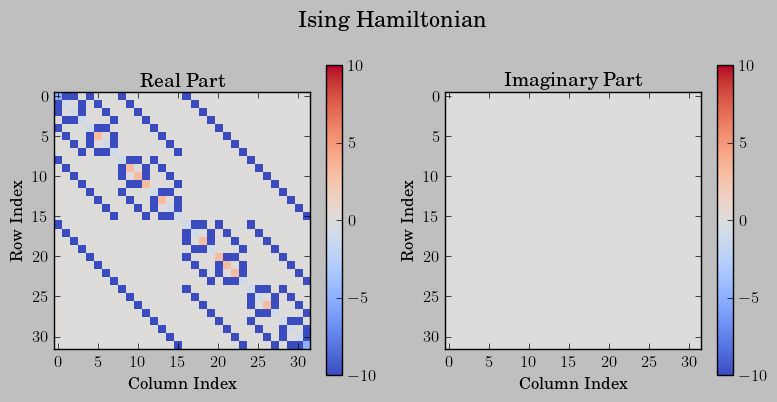

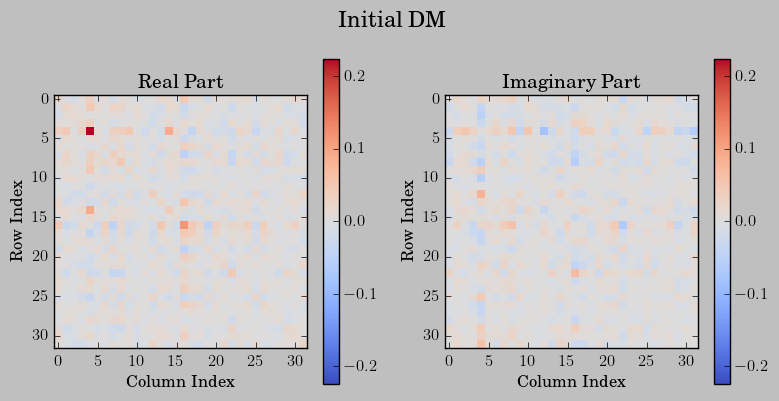

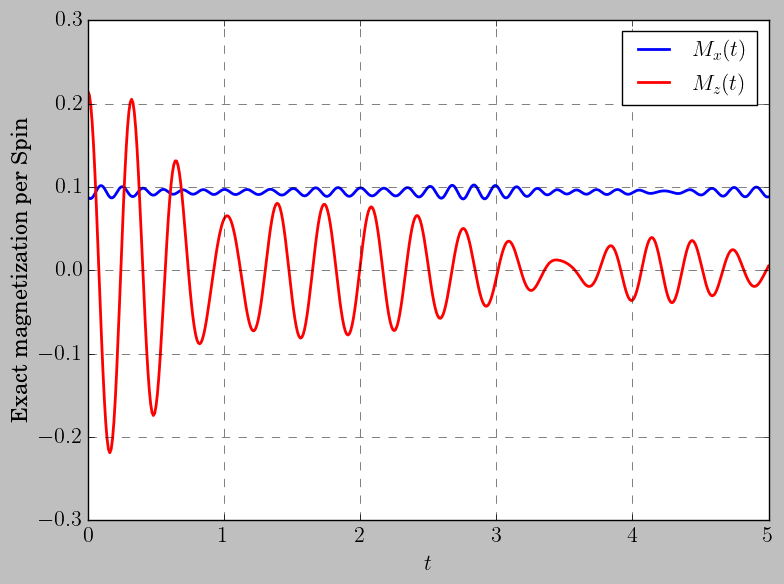

In [7]:
initialize_ising_system(J_val=1.0, h_val=10.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=None)
# rho0_ground - ground state density matrix
# rho0_pure_z - pure state |000...0> density matrix
# rho0_max_mixed - maximally mixed state density matrix
# rho0_random - a random density matrix

# Evolve the density matrix exactly. 
Ustep = expm(-1j * H * dt)
rho0 = rho0_random;  plot_matrix_heatmap(rho0, "Initial DM")
rho_t = np.zeros((Nt, dim, dim), dtype=complex)
rho_t = evolve_density_matrix(Ustep, rho0, Nt)

# Compute Trotterized time evolution operators
U_trotter = trotterize_H_to_U(H_terms, dt)
# Evolve the density matrix using Trotterized operators
rho_t_trotter = evolve_density_matrix_trotter(U_trotter, rho0, Nt)

# Compute the magnetization per spin
Xmagnetization = compute_magnetization(rho_t, Mx)
Zmagnetization = compute_magnetization(rho_t, Mz)

# Plot the magnetization over time
plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)  # Adjust figure size and DPI
plt.plot(t, Xmagnetization, label=r"$M_x(t)$", color="blue", linewidth=2)
plt.plot(t, Zmagnetization, label=r"$M_z(t)$", color="red", linewidth=2)
plt.xlabel(r"$t$", fontsize=fs)
plt.ylabel(r"Exact magnetization per Spin", fontsize=fs)
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



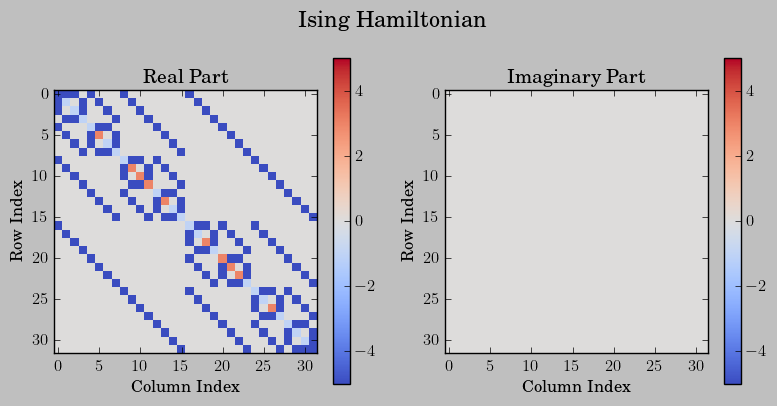

Nops shallow = 19
Nops wide = 1023
Nops hybrid = 1023


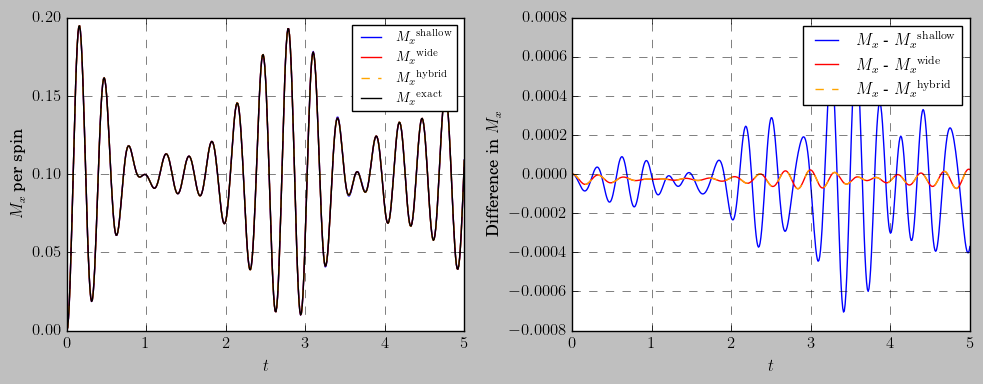

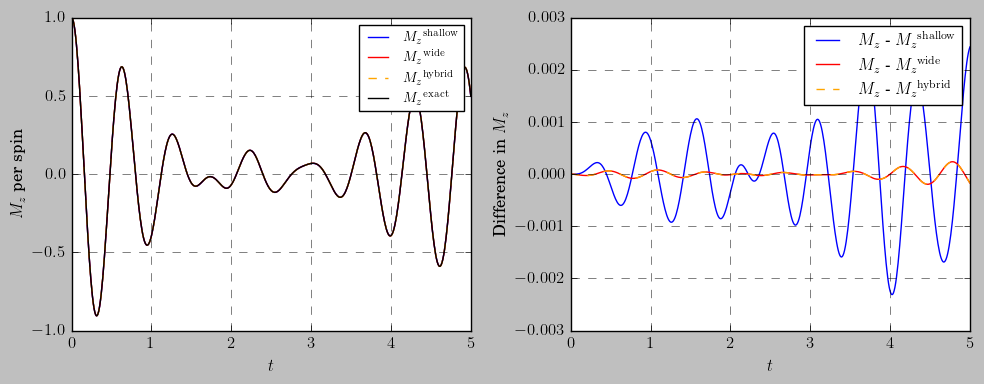

/Users/mattlane/Library/Python/3.9/lib/python/site-packages/scipy/linalg/_matfuncs.py:203: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)
/Users/mattlane/Library/Python/3.9/lib/python/site-packages/scipy/linalg/_matfuncs.py:203: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)


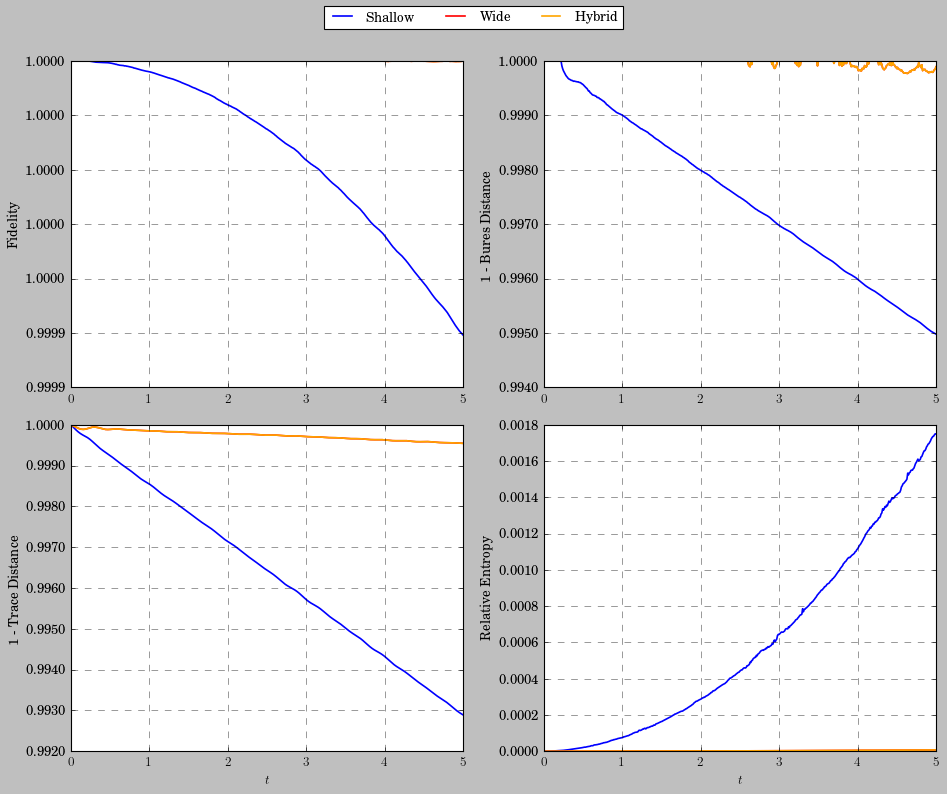

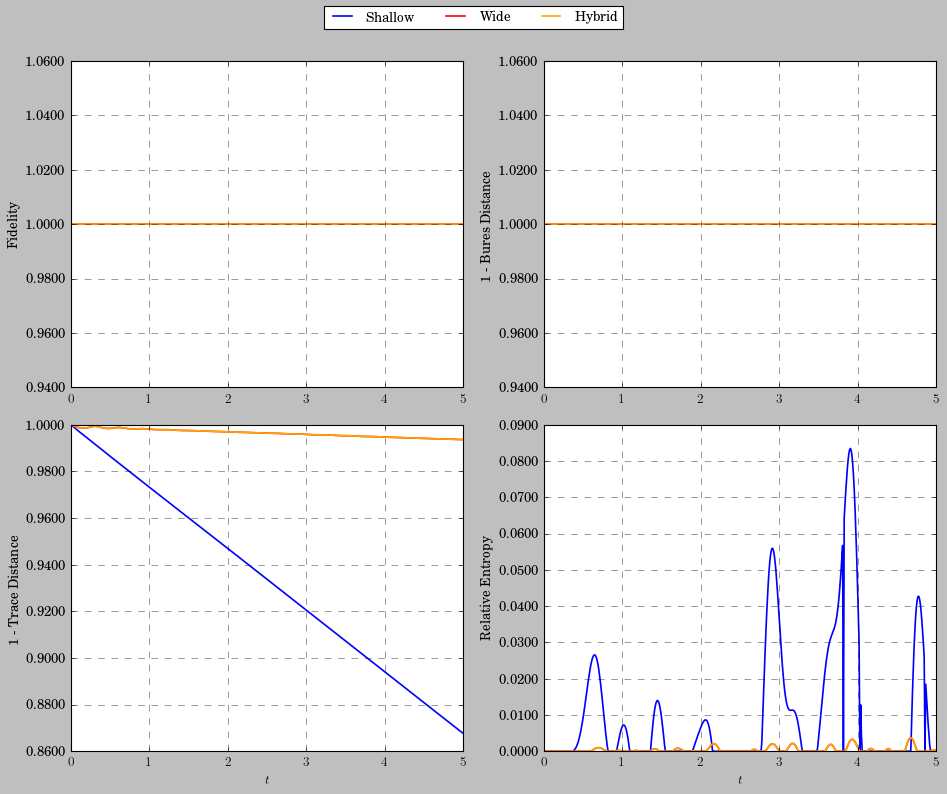

In [8]:
initialize_ising_system(J_val=1.0, h_val=5.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=0)

# Set the initial condition for rho. rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
rho0 = rho0_pure_z

# Evolve the density matrix exactly
Ustep = expm(-1j * H * dt)
rho_t = evolve_density_matrix(Ustep, rho0, Nt)
# Compute the exact magnetization per spin
Xmagnetization = compute_magnetization(rho_t, Mx)
Zmagnetization = compute_magnetization(rho_t, Mz)

# Shallow decomposition. 
shallow_decomposition, U_shallow_total, rho_t_shallow, Xmagnetization_shallow, Zmagnetization_shallow = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow")
# Wide decomposition. 
wide_decomposition, U_wide_total, rho_t_wide, Xmagnetization_wide, Zmagnetization_wide = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="wide")
# Hybrid decomposition. 
hybrid_decomposition, U_hybrid_total, rho_t_hybrid, Xmagnetization_hybrid, Zmagnetization_hybrid = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="hybrid")

# Compute Mx differences
delta_Xmagnetization_shallow = Xmagnetization - Xmagnetization_shallow
delta_Xmagnetization_wide = Xmagnetization - Xmagnetization_wide
delta_Xmagnetization_hybrid = Xmagnetization - Xmagnetization_hybrid

plot_magnetizations(t, Xmagnetization, Xmagnetization_shallow, Xmagnetization_wide, Xmagnetization_hybrid, 
                       delta_Xmagnetization_shallow, delta_Xmagnetization_wide, delta_Xmagnetization_hybrid, magnetization_label="$M_x$")

# Compute Mz differences
delta_Zmagnetization_shallow = Zmagnetization - Zmagnetization_shallow
delta_Zmagnetization_wide = Zmagnetization - Zmagnetization_wide
delta_Zmagnetization_hybrid = Zmagnetization - Zmagnetization_hybrid

plot_magnetizations(t, Zmagnetization, Zmagnetization_shallow, Zmagnetization_wide, Zmagnetization_hybrid, 
                       delta_Zmagnetization_shallow, delta_Zmagnetization_wide, delta_Zmagnetization_hybrid, magnetization_label="$M_z$")

# Compute and plot distances
distances_shallow = distance_measures(rho_t, rho_t_shallow)
distances_wide = distance_measures(rho_t, rho_t_wide)
distances_hybrid = distance_measures(rho_t, rho_t_hybrid)
plot_distance_measures(distances_shallow, distances_wide, distances_hybrid, t)
Ustep_series = generate_propagator_time_series(Ustep, Nt)
Udistances_shallow = distance_measures(Ustep_series, generate_propagator_time_series(U_shallow_total, Nt))
Udistances_wide = distance_measures(Ustep_series, generate_propagator_time_series(U_wide_total, Nt))
Udistances_hybrid = distance_measures(Ustep_series, generate_propagator_time_series(U_hybrid_total, Nt))
plot_distance_measures(Udistances_shallow, Udistances_wide, Udistances_hybrid, t)



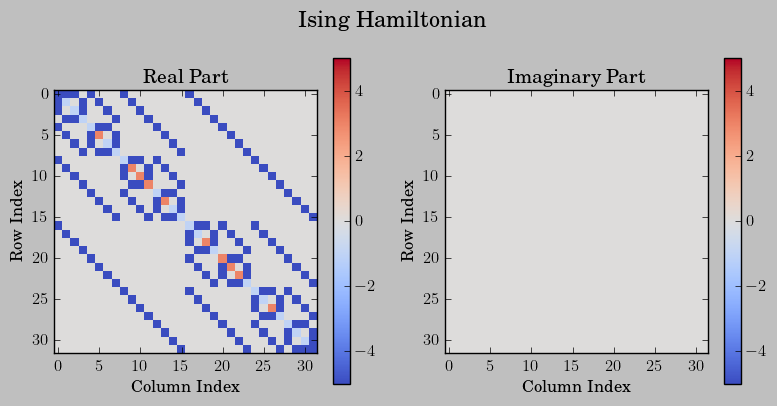

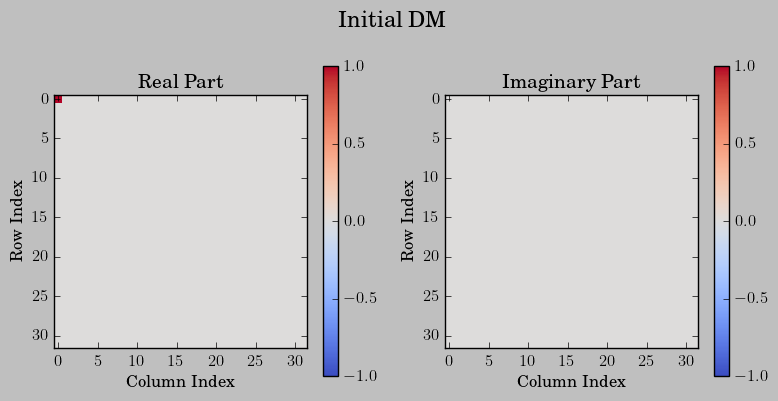

Nops shallow = 19
Nops forced (wide_probability=0.1) = 35
Nops forced (wide_probability=0.2) = 47
Nops forced (wide_probability=0.3) = 59
Nops forced (wide_probability=0.4) = 79
Nops forced (wide_probability=0.5) = 123
Nops forced (wide_probability=0.6) = 171
Nops forced (wide_probability=0.7) = 211
Nops forced (wide_probability=0.8) = 323
Nops forced (wide_probability=0.9) = 515
Nops wide = 1023
Nops hybrid = 1023


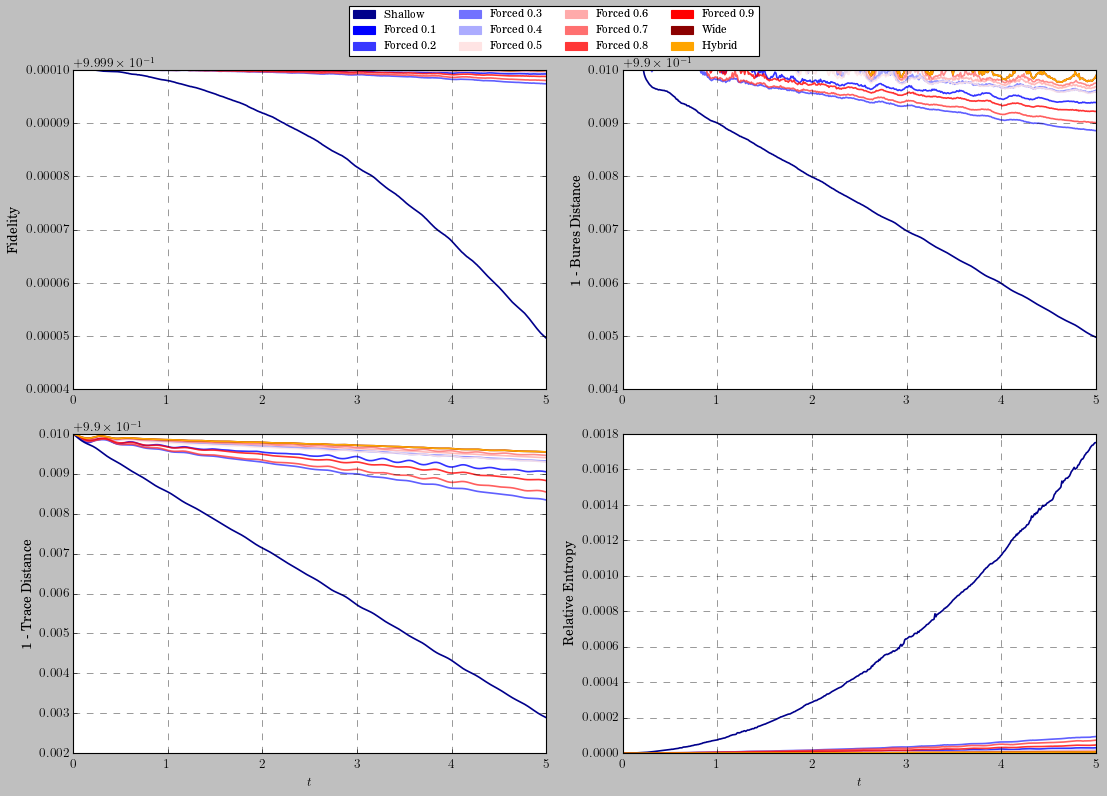

In [9]:
initialize_ising_system(J_val=1.0, h_val=5.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=None)
# Set the initial condition for rho. rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
rho0 = rho0_pure_z;  plot_matrix_heatmap(rho0, "Initial DM")

# Evolve the density matrix exactly
Ustep = expm(-1j * H * dt)
rho_t = evolve_density_matrix(Ustep, rho0, Nt)
# Compute the exact magnetization per spin
Xmagnetization = compute_magnetization(rho_t, Mx)
Zmagnetization = compute_magnetization(rho_t, Mz)

# Shallow decomposition. 
shallow_decomposition, U_shallow_total, rho_t_shallow, Xmagnetization_shallow, Zmagnetization_shallow = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow")
delta_Xmagnetization_shallow = Xmagnetization - Xmagnetization_shallow
delta_Zmagnetization_shallow = Zmagnetization - Zmagnetization_shallow
distances_shallow = distance_measures(rho_t, rho_t_shallow)

# Forced decomposition sweep from shallow to wide
wide_probabilities = np.arange(0.1, 1.0, 0.1)
num_probs = len(wide_probabilities)
# Preallocate arrays to store the decompositions
forced_decompositions = [None] * num_probs  # List for forced decompositions of variable length
# Preallocate arrays to store time series results
U_forced_totals = np.zeros((num_probs, dim, dim), dtype=complex)  
rho_t_forced = np.zeros((num_probs, Nt, dim, dim), dtype=complex)
Xmagnetization_forced = np.zeros((num_probs, Nt))
Zmagnetization_forced = np.zeros((num_probs, Nt))
delta_Xmagnetization_forced = np.zeros((num_probs, Nt))
delta_Zmagnetization_forced = np.zeros((num_probs, Nt))
# Preallocate dictionary to store distances for each wide_probability
distances_forced = {prob: {} for prob in wide_probabilities}
# Loop over wide_probability values
for i, wide_prob in enumerate(wide_probabilities):
    forced_decompositions[i], U_forced_totals[i], rho_t_forced[i], Xmagnetization_forced[i], Zmagnetization_forced[i] = decompose_and_evolve(H_terms,dt,rho0,Nt,Mx,Mz,decomposition="forced",wide_probability=wide_prob)
    # print(f"Nops forced (wide_probability={wide_prob:.1f}) =", forced_decompositions[i].shape[0])
    delta_Xmagnetization_forced[i] = Xmagnetization - Xmagnetization_forced[i]
    delta_Zmagnetization_forced[i] = Zmagnetization - Zmagnetization_forced[i]
    distances_forced[wide_prob] = distance_measures(rho_t, rho_t_forced[i])
    
# Wide decomposition. 
wide_decomposition, U_wide_total, rho_t_wide, Xmagnetization_wide, Zmagnetization_wide = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="wide")
delta_Xmagnetization_wide = Xmagnetization - Xmagnetization_wide
delta_Zmagnetization_wide = Zmagnetization - Zmagnetization_wide
distances_wide = distance_measures(rho_t, rho_t_wide)

# Hybrid decomposition. 
hybrid_decomposition, U_hybrid_total, rho_t_hybrid, Xmagnetization_hybrid, Zmagnetization_hybrid = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="hybrid")
delta_Xmagnetization_hybrid = Xmagnetization - Xmagnetization_hybrid
delta_Zmagnetization_hybrid = Zmagnetization - Zmagnetization_hybrid
distances_hybrid = distance_measures(rho_t, rho_t_hybrid)

plot_distance_measures_all(distances_shallow, distances_forced, distances_wide, distances_hybrid, t, wide_probabilities)


System with random Hamiltonian

Single-qubit terms: X, X, Z, Z, Z
Two-qubit terms: YY, XX, ZY, XY, YY


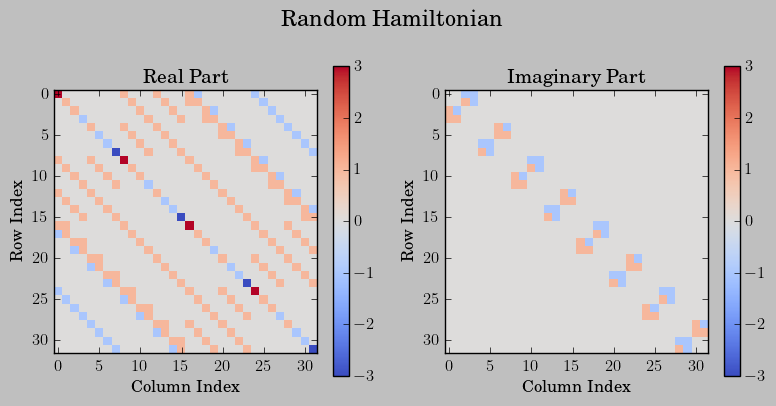

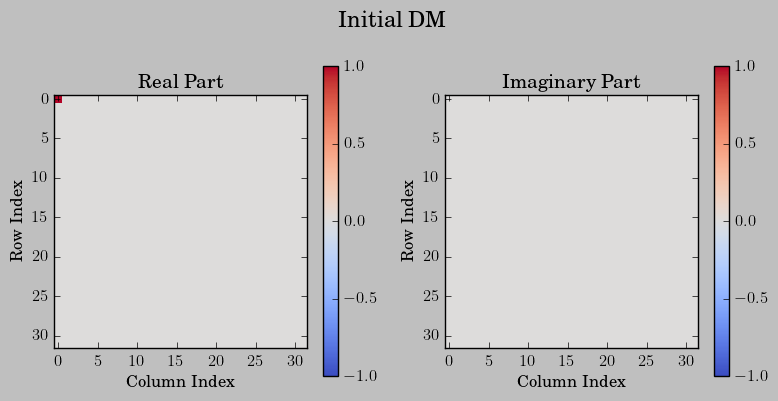

Nops shallow = 19
Nops wide = 1023
Nops hybrid = 1023


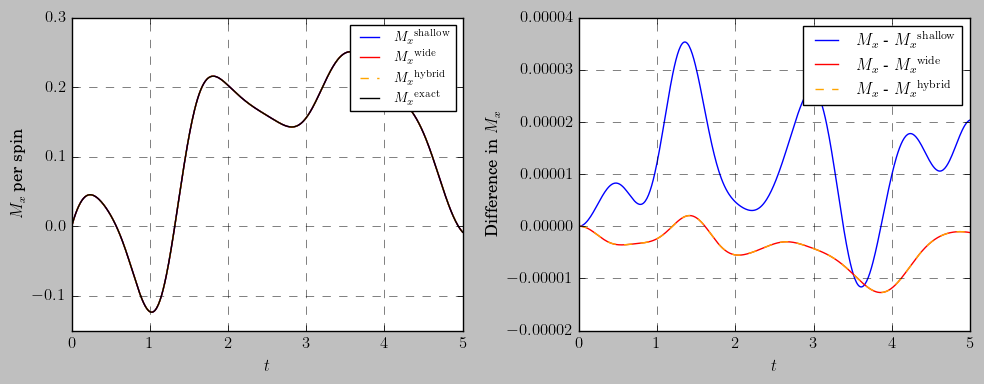

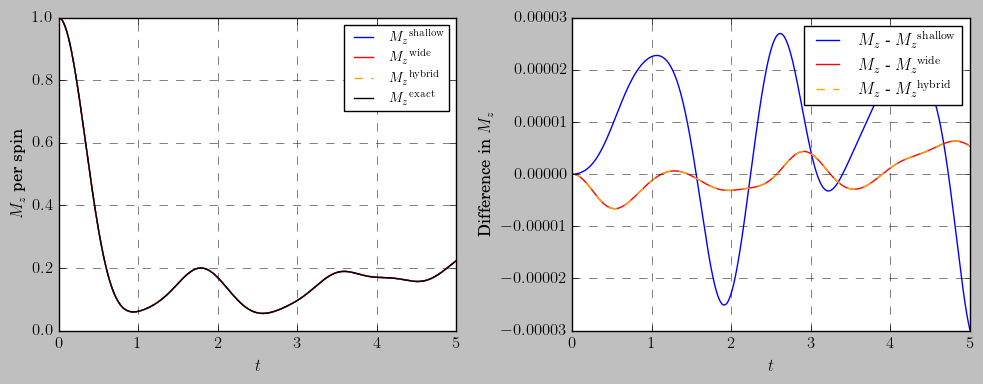

Nops forced (wide_probability=0.1) = 35
Nops forced (wide_probability=0.2) = 47
Nops forced (wide_probability=0.3) = 59
Nops forced (wide_probability=0.4) = 79
Nops forced (wide_probability=0.5) = 123
Nops forced (wide_probability=0.6) = 171
Nops forced (wide_probability=0.7) = 211
Nops forced (wide_probability=0.8) = 323
Nops forced (wide_probability=0.9) = 515


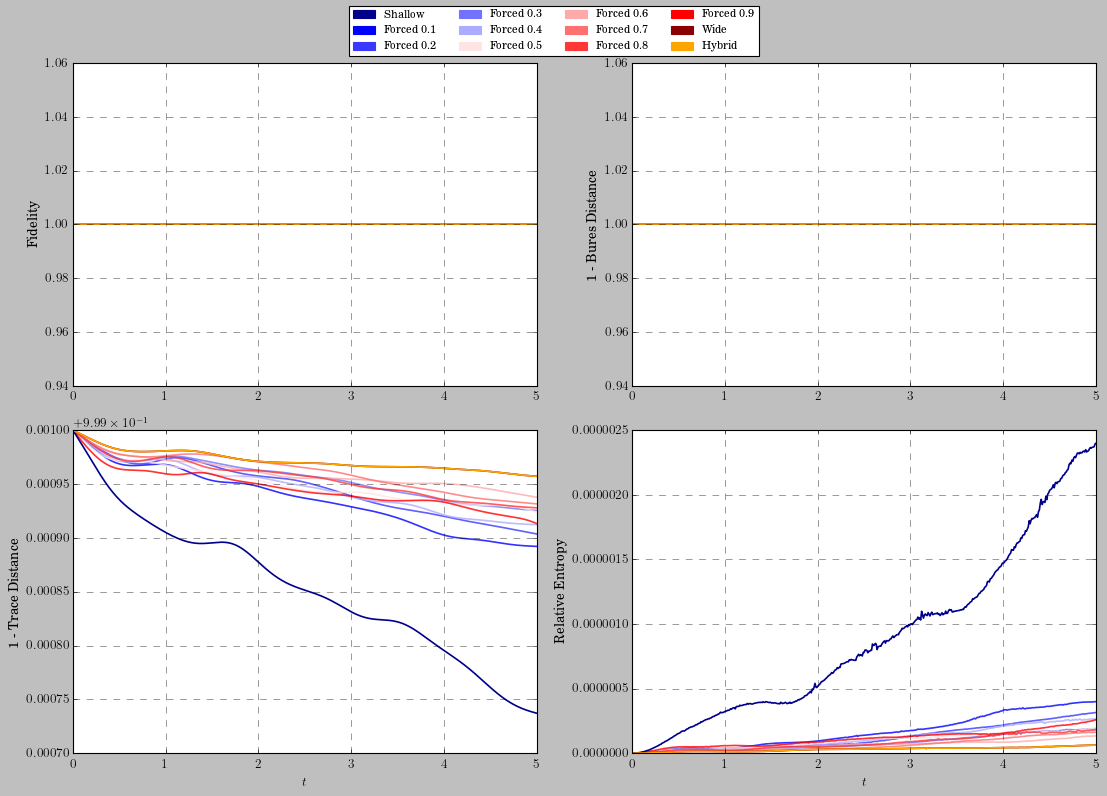

In [10]:
initialize_random_system(L_val=5, dt_val=0.01, t_max_val=5, H_seed_val=None, rho_seed_val=0)
# Set the initial condition for rho. rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
rho0 = rho0_pure_z;  plot_matrix_heatmap(rho0, "Initial DM")

# Evolve the density matrix exactly
Ustep = expm(-1j * H * dt)
rho_t = evolve_density_matrix(Ustep, rho0, Nt)
Xmagnetization = compute_magnetization(rho_t, Mx);  Zmagnetization = compute_magnetization(rho_t, Mz)

# Shallow decomposition. 
shallow_decomposition, U_shallow_total, rho_t_shallow, Xmagnetization_shallow, Zmagnetization_shallow = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow")
delta_Xmagnetization_shallow = Xmagnetization - Xmagnetization_shallow
delta_Zmagnetization_shallow = Zmagnetization - Zmagnetization_shallow
distances_shallow = distance_measures(rho_t, rho_t_shallow)

# Wide decomposition. 
wide_decomposition, U_wide_total, rho_t_wide, Xmagnetization_wide, Zmagnetization_wide = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="wide")
delta_Xmagnetization_wide = Xmagnetization - Xmagnetization_wide
delta_Zmagnetization_wide = Zmagnetization - Zmagnetization_wide
distances_wide = distance_measures(rho_t, rho_t_wide)

# Hybrid decomposition. 
hybrid_decomposition, U_hybrid_total, rho_t_hybrid, Xmagnetization_hybrid, Zmagnetization_hybrid = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="hybrid")
delta_Xmagnetization_hybrid = Xmagnetization - Xmagnetization_hybrid
delta_Zmagnetization_hybrid = Zmagnetization - Zmagnetization_hybrid
distances_hybrid = distance_measures(rho_t, rho_t_hybrid)

plot_magnetizations(t, Xmagnetization, Xmagnetization_shallow, Xmagnetization_wide, Xmagnetization_hybrid, 
                       delta_Xmagnetization_shallow, delta_Xmagnetization_wide, delta_Xmagnetization_hybrid, magnetization_label="$M_x$")
plot_magnetizations(t, Zmagnetization, Zmagnetization_shallow, Zmagnetization_wide, Zmagnetization_hybrid, 
                       delta_Zmagnetization_shallow, delta_Zmagnetization_wide, delta_Zmagnetization_hybrid, magnetization_label="$M_z$")
# plot_distance_measures(distances_shallow, distances_wide, distances_hybrid, t)

# Forced decomposition sweep from shallow to wide
wide_probabilities = np.arange(0.1, 1.0, 0.1)
num_probs = len(wide_probabilities)
# Preallocate arrays to store the decompositions
forced_decompositions = [None] * num_probs  # List for forced decompositions of variable length
# Preallocate arrays to store time series results
U_forced_totals = np.zeros((num_probs, dim, dim), dtype=complex)  
rho_t_forced = np.zeros((num_probs, Nt, dim, dim), dtype=complex)
Xmagnetization_forced = np.zeros((num_probs, Nt))
Zmagnetization_forced = np.zeros((num_probs, Nt))
delta_Xmagnetization_forced = np.zeros((num_probs, Nt))
delta_Zmagnetization_forced = np.zeros((num_probs, Nt))
# Preallocate dictionary to store distances for each wide_probability
distances_forced = {prob: {} for prob in wide_probabilities}
# Loop over wide_probability values
for i, wide_prob in enumerate(wide_probabilities):
    forced_decompositions[i], U_forced_totals[i], rho_t_forced[i], Xmagnetization_forced[i], Zmagnetization_forced[i] = decompose_and_evolve(H_terms,dt,rho0,Nt,Mx,Mz,decomposition="forced",wide_probability=wide_prob)
    # print(f"Nops forced (wide_probability={wide_prob:.1f}) =", forced_decompositions[i].shape[0])
    delta_Xmagnetization_forced[i] = Xmagnetization - Xmagnetization_forced[i]
    delta_Zmagnetization_forced[i] = Zmagnetization - Zmagnetization_forced[i]
    distances_forced[wide_prob] = distance_measures(rho_t, rho_t_forced[i])

plot_distance_measures_all(distances_shallow, distances_forced, distances_wide, distances_hybrid, t, wide_probabilities)


Average over random Hamiltonians. 

In [12]:
num_iterations = 1  # Number of random Hamiltonians to generate
# Forced decomposition sweep from shallow to wide
wide_probabilities = np.arange(0.1, 1.0, 0.1)
num_probs = len(wide_probabilities)
L = 5
dt = 0.01
t_max = 5

final_distances = {
    "shallow": {key: [] for key in ["fidelity", "bures_distance", "trace_distance", "relative_entropy", "frobenius_distance"]},
    "wide": {key: [] for key in ["fidelity", "bures_distance", "trace_distance", "relative_entropy", "frobenius_distance"]},
    "hybrid": {key: [] for key in ["fidelity", "bures_distance", "trace_distance", "relative_entropy", "frobenius_distance"]},
    "forced": {prob: {key: [] for key in ["fidelity", "bures_distance", "trace_distance", "relative_entropy", "frobenius_distance"]} for prob in wide_probabilities}
}

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1} / {num_iterations}", end='\r')
    # Suppress print statements
    with contextlib.redirect_stdout(io.StringIO()):

        # Generate a random Hamiltonian and initialize the system
        initialize_random_system(L_val=L, dt_val=dt, t_max_val=t_max, H_seed_val=None, rho_seed_val=None, plot_val=False)
        # Set the initial condition for rho. rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
        rho0 = rho0_pure_z 

        # Exact evolution
        Ustep = expm(-1j * H * dt);  rho_t = evolve_density_matrix(Ustep, rho0, Nt)

        # Shallow decomposition
        _, _, rho_t_shallow, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow")
        distances_shallow = distance_measures(rho_t, rho_t_shallow)
        for key in distances_shallow:
            final_distances["shallow"][key].append(distances_shallow[key][-1])

        # Forced decomposition for each wide_prob
        for i, wide_prob in enumerate(wide_probabilities):
            _, _, rho_t_forced, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="forced", wide_probability=wide_prob)
            distances = distance_measures(rho_t, rho_t_forced)
            for key in distances:
                final_distances["forced"][wide_prob][key].append(distances[key][-1])

        # Wide decomposition
        _, _, rho_t_wide, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="wide")
        distances_wide = distance_measures(rho_t, rho_t_wide)
        for key in distances_wide:
            final_distances["wide"][key].append(distances_wide[key][-1])

        # Hybrid decomposition
        _, _, rho_t_hybrid, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="hybrid")
        distances_hybrid = distance_measures(rho_t, rho_t_hybrid)
        for key in distances_hybrid:
            final_distances["hybrid"][key].append(distances_hybrid[key][-1])

# Post-processing for dictionary 
processed_distances = {
    "shallow": {},
    "wide": {},
    "hybrid": {},
    "forced": {prob: {} for prob in wide_probabilities}
}
# Process the distances for shallow, wide, and hybrid decompositions
for decomp in ["shallow", "wide", "hybrid"]:
    for key, values in final_distances[decomp].items():
        if key in ["bures_distance", "trace_distance"]:
            processed_key = f"1 - {key}"
            processed_values = [1 - value for value in values]
        else:
            processed_key = key
            processed_values = values
        processed_distances[decomp][processed_key] = processed_values
# Process the distances for forced decomposition
for prob in wide_probabilities:
    for key, values in final_distances["forced"][prob].items():
        if key in ["bures_distance", "trace_distance"]:
            processed_key = f"1 - {key}"
            processed_values = [1 - value for value in values]
        else:
            processed_key = key
            processed_values = values
        processed_distances["forced"][prob][processed_key] = processed_values

# I need to have it so that the Nops for a decomposition is always an output of the decomposition. This will mean editing the decomposition functions, as well 
# all the functions which call the decomposition functions. The reason for doing this is it would be good to know for a random H what are the Nops for forced
# vs the different forced decompositions? Want to be able to ask a question like is forced X=0.1 always on-par/better than hybrid and at the cost of smaller Nops?

In [ ]:
# List of distance measures to plot
distance_measures_list = ["fidelity", "1 - bures_distance", "1 - trace_distance", "relative_entropy"]

# Create subplots: one plot per distance measure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot for each distance measure
for i, measure in enumerate(distance_measures_list):
    ax = axes[i]
    
    # Prepare data for shallow, wide, and hybrid decompositions
    x_labels = ["shallow", "wide", "hybrid"] + [f"forced {prob:.1f}" for prob in wide_probabilities]
    means = [np.mean(processed_distances[decomp][measure]) for decomp in ["shallow", "wide", "hybrid"]]
    std_devs = [np.std(processed_distances[decomp][measure]) for decomp in ["shallow", "wide", "hybrid"]]
    
    # Prepare data for forced decompositions
    for prob in wide_probabilities:
        means.append(np.mean(processed_distances["forced"][prob][measure]))
        std_devs.append(np.std(processed_distances["forced"][prob][measure]))

    # Plot with error bars
    x_positions = np.arange(len(x_labels))
    ax.errorbar(x_positions, means, yerr=std_devs, fmt='o', capsize=5, markersize=8, label=measure, color="blue")
    
    # Customize plot
    ax.set_title(f"{measure.capitalize()}", fontsize=14)
    ax.set_ylabel("Value", fontsize=12)
    ax.set_xlabel("Decomposition", fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.grid(True, linestyle="--", alpha=0.7)
    # ax.set_ylim(0, 1)  # Adjust y-axis limits as needed for all distance measures

    # Prevent scientific notation and exotic scaling
    ax.ticklabel_format(style="plain", axis="y")
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))  # decimal places
    ax.get_yaxis().get_offset_text().set_visible(False)  # Hide any offset notation

    # Add padding to x-axis limits to create space
    ax.set_xlim(-0.5, len(x_labels) - 0.5)

plt.tight_layout()
plt.show()

Heisenberg XYZ Hamiltonian

In [ ]:
initialize_heisenberg_system(Jx_val=3.0, Jy_val=1.0, Jz_val=1.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=None)
# Set the initial condition for rho. rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
rho0 = rho0_pure_z;  plot_matrix_heatmap(rho0, "Initial DM")

# Evolve the density matrix exactly
Ustep = expm(-1j * H * dt)
rho_t = evolve_density_matrix(Ustep, rho0, Nt)
# Compute the exact magnetization per spin
Xmagnetization = compute_magnetization(rho_t, Mx)
Zmagnetization = compute_magnetization(rho_t, Mz)

# Shallow decomposition. 
shallow_decomposition, U_shallow_total, rho_t_shallow, Xmagnetization_shallow, Zmagnetization_shallow = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow")
delta_Xmagnetization_shallow = Xmagnetization - Xmagnetization_shallow
delta_Zmagnetization_shallow = Zmagnetization - Zmagnetization_shallow
distances_shallow = distance_measures(rho_t, rho_t_shallow)

# Wide decomposition. 
wide_decomposition, U_wide_total, rho_t_wide, Xmagnetization_wide, Zmagnetization_wide = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="wide")
delta_Xmagnetization_wide = Xmagnetization - Xmagnetization_wide
delta_Zmagnetization_wide = Zmagnetization - Zmagnetization_wide
distances_wide = distance_measures(rho_t, rho_t_wide)

# Hybrid decomposition. 
hybrid_decomposition, U_hybrid_total, rho_t_hybrid, Xmagnetization_hybrid, Zmagnetization_hybrid = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="hybrid")
delta_Xmagnetization_hybrid = Xmagnetization - Xmagnetization_hybrid
delta_Zmagnetization_hybrid = Zmagnetization - Zmagnetization_hybrid
distances_hybrid = distance_measures(rho_t, rho_t_hybrid)

plot_magnetizations(t, Xmagnetization, Xmagnetization_shallow, Xmagnetization_wide, Xmagnetization_hybrid, 
                       delta_Xmagnetization_shallow, delta_Xmagnetization_wide, delta_Xmagnetization_hybrid, magnetization_label="$M_x$")
plot_magnetizations(t, Zmagnetization, Zmagnetization_shallow, Zmagnetization_wide, Zmagnetization_hybrid, 
                       delta_Zmagnetization_shallow, delta_Zmagnetization_wide, delta_Zmagnetization_hybrid, magnetization_label="$M_z$")

plot_distance_measures(distances_shallow, distances_wide, distances_hybrid, t)

# Forced decomposition sweep from shallow to wide
wide_probabilities = np.arange(0.1, 1.0, 0.1)
num_probs = len(wide_probabilities)
# Preallocate arrays to store the decompositions
forced_decompositions = [None] * num_probs  # List for forced decompositions of variable length
# Preallocate arrays to store time series results
U_forced_totals = np.zeros((num_probs, dim, dim), dtype=complex)  
rho_t_forced = np.zeros((num_probs, Nt, dim, dim), dtype=complex)
Xmagnetization_forced = np.zeros((num_probs, Nt))
Zmagnetization_forced = np.zeros((num_probs, Nt))
delta_Xmagnetization_forced = np.zeros((num_probs, Nt))
delta_Zmagnetization_forced = np.zeros((num_probs, Nt))
# Preallocate dictionary to store distances for each wide_probability
distances_forced = {prob: {} for prob in wide_probabilities}
# Loop over wide_probability values
for i, wide_prob in enumerate(wide_probabilities):
    forced_decompositions[i], U_forced_totals[i], rho_t_forced[i], Xmagnetization_forced[i], Zmagnetization_forced[i] = decompose_and_evolve(H_terms,dt,rho0,Nt,Mx,Mz,decomposition="forced",wide_probability=wide_prob)
    # print(f"Nops forced (wide_probability={wide_prob:.1f}) =", forced_decompositions[i].shape[0])
    delta_Xmagnetization_forced[i] = Xmagnetization - Xmagnetization_forced[i]
    delta_Zmagnetization_forced[i] = Zmagnetization - Zmagnetization_forced[i]
    distances_forced[wide_prob] = distance_measures(rho_t, rho_t_forced[i])

plot_distance_measures_all(distances_shallow, distances_forced, distances_wide, distances_hybrid, t, wide_probabilities)


Single step

In [ ]:
initialize_ising_system(J_val=1.0, h_val=5.0, L_val=5, dt_val=0.1, t_max_val=0.1, seed_val=0)

# Set the initial condition for rho. rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
rho0 = rho0_pure_z

# Evolve the density matrix exactly
Ustep = expm(-1j * H * dt)
rho_t = Ustep @ rho0 @ Ustep.conj().T

# Shallow decomposition. 
shallow_decomposition, U_shallow_total, rho_t_shallow, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow")
shallow_distances = distance_measures(rho_t,rho_t_shallow[1])
# Hybrid decomposition. 
hybrid_decomposition, U_hybrid_total, rho_t_hybrid, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="hybrid")
hybrid_distances = distance_measures(rho_t,rho_t_hybrid[1])
# Wide decomposition. 
wide_decomposition, U_wide_total, rho_t_wide, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="wide")
wide_distances = distance_measures(rho_t,rho_t_wide[1])


Nops_list = []
Nops_list.append(shallow_decomposition.shape[0])
Nops_list.append(hybrid_decomposition.shape[0])
Nops_list.append(wide_decomposition.shape[0])

fidelities_list = []
fidelities_list.append(shallow_distances["fidelity"])
fidelities_list.append(hybrid_distances["fidelity"])
fidelities_list.append(wide_distances["fidelity"])

bures_list = []
bures_list.append(shallow_distances["bures_distance"])
bures_list.append(hybrid_distances["bures_distance"])
bures_list.append(wide_distances["bures_distance"])

frobenius_list = []
frobenius_list.append(shallow_distances["frobenius_distance"])
frobenius_list.append(hybrid_distances["frobenius_distance"])
frobenius_list.append(wide_distances["frobenius_distance"])

trace_list = []
trace_list.append(shallow_distances["trace_distance"])
trace_list.append(hybrid_distances["trace_distance"])
trace_list.append(wide_distances["trace_distance"])

entropy_list = []
entropy_list.append(shallow_distances["relative_entropy"])
entropy_list.append(hybrid_distances["relative_entropy"])
entropy_list.append(wide_distances["relative_entropy"])


# Forced decomposition sweep from shallow to wide
wide_probabilities = np.arange(0.0, 1.1, 0.1)
num_probs = len(wide_probabilities)
# Preallocate arrays to store the decompositions
forced_decompositions = [None] * num_probs  # List for forced decompositions of variable length
# Preallocate arrays to store time series results
U_forced_totals = np.zeros((num_probs, dim, dim), dtype=complex)  
rho_t_forced = np.zeros((num_probs, Nt, dim, dim), dtype=complex)
# Preallocate dictionary to store distances for each wide_probability
distances_forced = {prob: {} for prob in wide_probabilities}
# Loop over wide_probability values
for i, wide_prob in enumerate(wide_probabilities):
    forced_decompositions[i], U_forced_totals[i], rho_t_forced[i], _, _ = decompose_and_evolve(H_terms,dt,rho0,Nt,Mx,Mz,decomposition="forced",wide_probability=wide_prob)
    distances_forced[wide_prob] = distance_measures(rho_t, rho_t_forced[i][1])

    Nops_list.append(forced_decompositions[i].shape[0])
    fidelities_list.append(distances_forced[wide_prob]["fidelity"])
    bures_list.append(distances_forced[wide_prob]["bures_distance"])
    frobenius_list.append(distances_forced[wide_prob]["frobenius_distance"])
    trace_list.append(distances_forced[wide_prob]["trace_distance"])
    entropy_list.append(distances_forced[wide_prob]["relative_entropy"])


fig, ax = plt.subplots(figsize=(7,5))
ax.plot([0,Nops_list[-1]+10],[1-fidelities_list[0],1-fidelities_list[0]],c="b")
ax.plot([0,Nops_list[-1]+10],[1-fidelities_list[1],1-fidelities_list[1]],c="orange")
ax.plot([0,Nops_list[-1]+10],[1-fidelities_list[2],1-fidelities_list[2]],c="r")
ax.scatter(Nops_list[3:],1-np.array(fidelities_list[3:]),c='b')
ax.set_yscale("log")
ax.set_xlim(0,Nops_list[-1]+10)
# ax.set_ylim(0)
ax.set_xlabel("decomposition length")
ax.set_ylabel("1 - Fidelity")
plt.show()

fig, ax = plt.subplots(figsize=(7,5))
ax.plot([0,Nops_list[-1]+10],[bures_list[0],bures_list[0]],c="b")
ax.plot([0,Nops_list[-1]+10],[bures_list[1],bures_list[1]],c="orange")
ax.plot([0,Nops_list[-1]+10],[bures_list[2],bures_list[2]],c="r")
ax.scatter(Nops_list[3:],bures_list[3:],c='b')
# ax.set_yscale("log")
ax.set_xlim(0,Nops_list[-1]+10)
ax.set_ylim(0)
ax.set_xlabel("decomposition length")
ax.set_ylabel("Bures distance")
plt.show()

fig, ax = plt.subplots(figsize=(7,5))
ax.plot([0,Nops_list[-1]+10],[trace_list[0],trace_list[0]],c="b")
ax.plot([0,Nops_list[-1]+10],[trace_list[1],trace_list[1]],c="orange")
ax.plot([0,Nops_list[-1]+10],[trace_list[2],trace_list[2]],c="r")
ax.scatter(Nops_list[3:],trace_list[3:],c='b')
# ax.set_yscale("log")
ax.set_xlim(0,Nops_list[-1]+10)
ax.set_ylim(0)
ax.set_xlabel("decomposition length")
ax.set_ylabel("Trace distance")
plt.show()

fig, ax = plt.subplots(figsize=(7,5))
ax.plot([0,Nops_list[-1]+10],[entropy_list[0],entropy_list[0]],c="b")
ax.plot([0,Nops_list[-1]+10],[entropy_list[1],entropy_list[1]],c="orange")
ax.plot([0,Nops_list[-1]+10],[entropy_list[2],entropy_list[2]],c="r")
ax.scatter(Nops_list[3:],entropy_list[3:],c='b')
ax.set_yscale("log")
ax.set_xlim(0,Nops_list[-1]+10)
# ax.set_ylim(0)
ax.set_xlabel("decomposition length")
ax.set_ylabel("Relative entropy")
plt.show()




Noisy TFIM

In [68]:
initialize_ising_system(J_val=1.0, h_val=5.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=0)
rho0 = rho0_pure_z
Ustep = expm(-1j * H * dt)
rho_t = evolve_density_matrix(Ustep, rho0, Nt)
Zmagnetization = compute_magnetization(rho_t, Mz);  finalZ = Zmagnetization[-1]

shallow_decomposition = shallow_decomposition_recursive(H_terms, dt)
Nops_shallow = shallow_decomposition.shape[0]
rho_t_shallow = np.zeros((Nt, rho0.shape[0], rho0.shape[0]), dtype=complex)
rho_t_shallow[0] = rho0
wide_decomposition = wide_decomposition_recursive(H_terms, dt)
Nops_wide = wide_decomposition.shape[0]
rho_t_wide = np.zeros((Nt, rho0.shape[0], rho0.shape[0]), dtype=complex)
rho_t_wide[0] = rho0
wide_prob = 0.1
forced_decomposition = forced_decomposition_recursive(H_terms, dt, wide_probability=wide_prob, wide_count=0, total_count=0)
Nops_forced = forced_decomposition.shape[0]
rho_t_forced = np.zeros((Nt, rho0.shape[0], rho0.shape[0]), dtype=complex)
rho_t_forced[0] = rho0

p_array = np.array([10**-pow for pow in range(2,12)])
delta_Zmagnetization_shallow, delta_Zmagnetization_wide, delta_Zmagnetization_forced = [], [], [] 
distances_shallow, distances_wide, distances_forced = [], [], []
for p in p_array:
    print(p,"/",p_array[-1])
    rho_t_shallow[:,:,:] = 0;  rho_t_shallow[0] = rho0
    rho_t_wide[:,:,:] = 0;  rho_t_wide[0] = rho0
    rho_t_forced[:,:,:] = 0;  rho_t_forced[0] = rho0
    for n in range(1, Nt):
        temp = rho_t_shallow[n - 1]
        for U in shallow_decomposition:
            temp = U @ temp @ dagger(U)
            temp = depolarise(temp, p)
        rho_t_shallow[n] = temp
        temp = rho_t_wide[n - 1]
        for U in wide_decomposition:
            temp = U @ temp @ dagger(U)
            temp = depolarise(temp, p)
        rho_t_wide[n] = temp
        temp = rho_t_forced[n - 1]
        for U in forced_decomposition:
            temp = U @ temp @ dagger(U)
            temp = depolarise(temp, p)
        rho_t_forced[n] = temp

    delta_Zmagnetization_shallow.append(finalZ - compute_magnetization(rho_t_shallow, Mz)[-1])
    delta_Zmagnetization_wide.append(finalZ - compute_magnetization(rho_t_wide, Mz)[-1])
    delta_Zmagnetization_forced.append(finalZ - compute_magnetization(rho_t_forced, Mz)[-1])
    distances_shallow.append(trace_distance(rho_t, rho_t_shallow)[-1])
    distances_wide.append(trace_distance(rho_t, rho_t_wide)[-1])
    distances_forced.append(trace_distance(rho_t, rho_t_forced)[-1])

delta_Zmagnetization_shallow = abs(np.array(delta_Zmagnetization_shallow)/finalZ)*100
delta_Zmagnetization_wide = abs(np.array(delta_Zmagnetization_wide)/finalZ)*100
delta_Zmagnetization_forced = abs(np.array(delta_Zmagnetization_forced)/finalZ)*100
distances_shallow = np.array(distances_shallow)
distances_wide = np.array(distances_wide)
distances_forced = np.array(distances_forced)

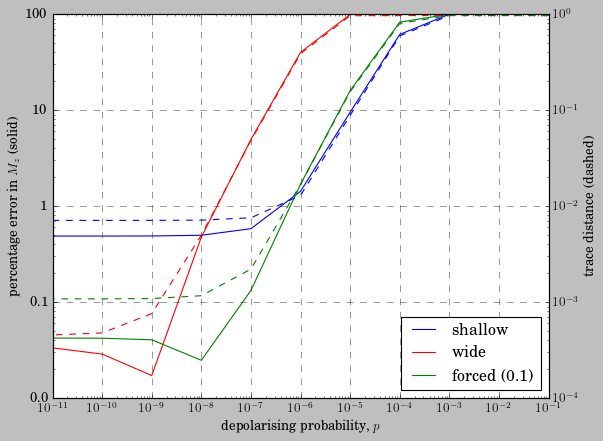

In [81]:

def clean_number_format(x, pos):
    if abs(x - int(x)) < 1e-8:
        return f"{int(x)}"
    else:
        return f"{x:.1f}"

fig, ax1 = plt.subplots()
ax1.plot(p_array, delta_Zmagnetization_shallow, color='blue', label=r'shallow')
ax1.plot(p_array, delta_Zmagnetization_wide, color='red', label=r'wide')
ax1.plot(p_array, delta_Zmagnetization_forced, color='green', label=r'forced (0.1)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(clean_number_format))
ax1.set_xlim(p_array[-1],p_array[0])
ax1.set_xlabel('depolarising probability, $p$')
ax1.legend(loc='lower right')
ax1.set_ylabel(r'percentage error in $M_z$ (solid)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax2 = ax1.twinx()
ax2.plot(p_array, distances_shallow, color='blue', linestyle='dashed')
ax2.plot(p_array, distances_wide, color='red', linestyle='dashed')
ax2.plot(p_array, distances_forced, color='green', linestyle='dashed')
ax2.set_yscale('log')
ax2.set_ylabel('trace distance (dashed)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which="major", linestyle="--", alpha=0.7)
plt.show()

Why is forced so good? Or, why is shallow so bad?

In [28]:
# For a given Hamiltonian, pick a term and do wide with that term, and then shallow for the rest. Do this for each term, to try and see what it is about doing just 
# one step of wide that gives such an improvement over shallow/hybrid. Also, see whether we can get a plot of the error bound which shows why wide performs better 
# than everything else. It may be that it's because of the factors of 1/2 that get picked up leading to supression of the error terms. 

In [ ]:
step = 0.1
initialize_ising_system(J_val=1.0, h_val=5.0, L_val=5, dt_val=step, t_max_val=step, seed_val=None)
# Set the initial condition for rho. rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
rho0 = rho0_pure_z

# Evolve the density matrix exactly
Ustep = expm(-1j * H * dt)
rho_exact = Ustep @ rho0 @ Ustep.conj().T

# Shallow decomposition. 
shallow_decomposition, U_shallow, rho_shallow, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="shallow")
shallow_distances = distance_measures(rho_exact,rho_shallow[1])
# Wide decomposition. 
wide_decomposition, U_wide, rho_wide, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="wide")
wide_distances = distance_measures(rho_exact,rho_wide[1])
# Hybrid decomposition. 
hybrid_decomposition, U_hybrid, rho_hybrid, _, _ = decompose_and_evolve(H_terms, dt, rho0, Nt, Mx, Mz, decomposition="hybrid")
hybrid_distances = distance_measures(rho_exact,rho_hybrid[1])

# Perform a decomposition where the first term in the decomposition is wide and the rest are shallow, for all possible first terms.  
term1wide_decomposition = [];  rho_term1wide = [];  term1wide_distances = []
for i in range(0,H_terms.shape[0]):
    this_term = H_terms[i, :, :]
    the_rest = np.sum(np.delete(H_terms, i, axis=0), axis=0)
    inner = expm(-1j * this_term * dt)
    outer = shallow_decomposition_recursive(0.5 * np.delete(H_terms, i, axis=0), dt)
    term1wide_decomposition.append(np.concatenate((outer, inner[None, :, :], outer), axis=0))
    if i == 0:
        print("Nops term1 wide =",term1wide_decomposition[0].shape[0])
    U = sequential_matrix_product(term1wide_decomposition[-1])
    rho_term1wide.append(U @ rho0 @ U.conj().T)
    term1wide_distances.append(distance_measures(rho_exact,rho_term1wide[-1]))

term1wide_decomposition = np.array(term1wide_decomposition)
rho_one_wide_step = np.array(rho_term1wide)

term1wide_distances_tmp = {
        "fidelity": [],
        "bures_distance": [],
        "frobenius_distance": [],
        "trace_distance": [],
        "relative_entropy": []
    }
for i in range(0,H_terms.shape[0]):
    term1wide_distances_tmp["fidelity"].append(term1wide_distances[i]["fidelity"])
    term1wide_distances_tmp["bures_distance"].append(term1wide_distances[i]["bures_distance"])
    term1wide_distances_tmp["frobenius_distance"].append(term1wide_distances[i]["frobenius_distance"])
    term1wide_distances_tmp["trace_distance"].append(term1wide_distances[i]["trace_distance"])
    term1wide_distances_tmp["relative_entropy"].append(term1wide_distances[i]["relative_entropy"])
term1wide_distances = term1wide_distances_tmp

fig, ax = plt.subplots(figsize=(7,5))
ax.plot([0,H_terms.shape[0]],[1-shallow_distances["fidelity"],1-shallow_distances["fidelity"]],c="b")
ax.plot([0,H_terms.shape[0]],[1-hybrid_distances["fidelity"],1-hybrid_distances["fidelity"]],c="orange")
ax.plot([0,H_terms.shape[0]],[1-wide_distances["fidelity"],1-wide_distances["fidelity"]],c="r")
ax.scatter(np.arange(0,H_terms.shape[0],1),1-np.array(term1wide_distances["fidelity"]))
ax.set_xlabel("wide term position index")
ax.set_ylabel("1 - Fidelity")
plt.show()



In [ ]:
def shallow_decomposition_sequential(terms, step, error_bounds=None):
    """
    Perform a sequential shallow Suzuki decomposition on an array of Hamiltonian terms.

    This function recursively pulls out terms in order (instead of optimizing term selection)
    while maintaining the Suzuki concatenation structure.

    Parameters:
        terms (np.ndarray): 3D array of Hamiltonian terms (shape: (num_terms, dim, dim)).
        step (float): Time step size.
        error_bounds (list, optional): Accumulates error bounds at each step.

    Returns:
        np.ndarray: 3D array of time evolution operators in the shallow decomposition order.
        np.ndarray: 1D array of error bounds associated with each step.
    """
    if error_bounds is None:
        error_bounds = []

    # Sequential term to pull out is always the first term in terms. 
    this_term = terms[0, :, :]
    the_rest = np.sum(np.delete(terms, 0, axis=0), axis=0)
    # Get the error bound for pulling out that term. 
    err = suzuki_decomposition_error(this_term, the_rest)
    error_bounds.append(err)

    Nterms = len(terms)
    if Nterms > 2:
        outer = expm(-1j * 0.5 * this_term * step)
        inner, error_bounds = shallow_decomposition_sequential(np.delete(terms, 0, axis=0), step, error_bounds)
        result = np.concatenate((outer[None, :, :], inner, outer[None, :, :]), axis=0)
    else:
        # Base case: Only two terms left
        outer = expm(-1j * 0.5 * this_term * step)
        inner = expm(-1j * the_rest * step)
        result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)

    return result, np.array(error_bounds)





def wide_decomposition_sequential(terms, step, error_bounds=None):
    """
    Perform a sequential wide Suzuki decomposition on an array of Hamiltonian terms.

    This function recursively pulls out terms in order (instead of optimizing term selection)
    while maintaining the Suzuki concatenation structure.

    Parameters:
        terms (np.ndarray): 3D array of Hamiltonian terms (shape: (num_terms, dim, dim)).
        step (float): Time step size.

    Returns:
        np.ndarray: 3D array of time evolution operators in the wide decomposition order.
        np.ndarray: 1D array of error bounds associated with each step.
    """
    if error_bounds is None:
        error_bounds = []

    # Sequential term to pull out is always the first term in terms. 
    this_term = terms[0, :, :]
    the_rest = np.sum(np.delete(terms, 0, axis=0), axis=0)
    # Get the error bound for pulling out that term. 
    err = suzuki_decomposition_error(the_rest, this_term)
    error_bounds.append(err)

    Nterms = len(terms)
    if Nterms > 2:
        # Compute the inner and outer operators
        inner = expm(-1j * terms[0, :, :] * step)
        outer, error_bounds = wide_decomposition_sequential(0.5 * np.delete(terms, 0, axis=0), step, error_bounds)
    else:
        # Base case: Only two terms left
        inner = expm(-1j * this_term * step)
        outer = expm(-1j * 0.5 * the_rest * step)

    # Assemble the result using np.concatenate
    if outer.ndim == 2:
        result = np.concatenate((outer[None, :, :], inner[None, :, :], outer[None, :, :]), axis=0)
    elif outer.ndim == 3:
        result = np.concatenate((outer, inner[None, :, :], outer), axis=0)
    else:
        raise ValueError("Unexpected outer.ndim. Expected 2 or 3.")

    return result, np.array(error_bounds)


################################################################################################################################################


initialize_ising_system(J_val=1.0, h_val=5.0, L_val=5, dt_val=0.01, t_max_val=5, seed_val=None)
rho0 = rho0_pure_z      # rho0_ground, rho0_pure_z, rho0_max_mixed, rho0_random
U_exact = expm(-1j * H * dt)
rho_exact = evolve_density_matrix(U_exact, rho0, Nt)
X_exact = compute_magnetization(rho_exact, Mx)

# Just sequential through the terms, not trying to pick an error-minimizing term. 
shallow_decomposition, shallow_err_array = shallow_decomposition_sequential(H_terms, dt)
shallow_U = sequential_matrix_product(shallow_decomposition)
shallow_rho = evolve_density_matrix(shallow_U, rho0, Nt)
shallow_X = compute_magnetization(shallow_rho, Mx)

# The original shallow decomposition which tries to pick the 'best' term for each step. 
shallowRec_decomposition = shallow_decomposition_recursive(H_terms, dt)
shallowRec_U = sequential_matrix_product(shallowRec_decomposition)
shallowRec_rho = evolve_density_matrix(shallowRec_U, rho0, Nt)
shallowRec_X = compute_magnetization(shallowRec_rho, Mx)

# Magnetization plot to check that it's working.
plt.plot(t,X_exact,c='k')
plt.plot(t,shallow_X,c='orange',ls='dashed')
plt.plot(t,shallowRec_X,c='r',ls='dashed')
plt.plot(t,X_exact-shallow_X,c='orange')
plt.plot(t,X_exact-shallowRec_X,c='r')
plt.show()

wide_decomposition, wide_err_array = wide_decomposition_sequential(H_terms, dt)
wide_U = sequential_matrix_product(wide_decomposition)
wide_rho = evolve_density_matrix(wide_U, rho0, Nt)
wide_X = compute_magnetization(wide_rho, Mx)

# wideRec_decomposition = wide_decomposition_recursive(H_terms, dt)
# wideRec_U = sequential_matrix_product(wideRec_decomposition)
# wideRec_rho = evolve_density_matrix(wideRec_U, rho0, Nt)
# wideRec_X = compute_magnetization(wideRec_rho, Mx)

# plt.plot(t,X_exact,c='k')
# plt.plot(t,wide_X,c='orange',ls='dashed')
# plt.plot(t,wideRec_X,c='r',ls='dashed')
# plt.plot(t,X_exact-wide_X,c='orange')
# plt.plot(t,X_exact-wideRec_X,c='r')
# plt.show()
